# HEALTH & NUTRITION
#### EXPLORING THE CORRELATION BETWEEN DIET, LIFESTYLE AND HEALTH

In this project, I explored what is the impact of the three most mainstream diets and of lifestyle on the health condition of people following those diets.


### About this Notebook

This Notebook follows the NHANES_Data_cleaning and the NHANES_Exploratory_Data notebooks. 

The final dataset is here used to predict the features most influencing health conditions.

## Modeling

There are three health conditions considered here: **High Blood Pressure, High Cholesterol Level, and Diabetes.** These conditions are highly correlated with nutrition habits and lifestyle. The goal is to understand which factor, or factors, influences their development the most. 

Each condition will be considered individually.  
Because a participant has a condition or not, this is a **binary classification problem.**

The best unsupervised algorithms to apply to a binary classification problem are (__[Source 1](https://en.wikipedia.org/wiki/Binary_classification)__, __[Source 2](https://machinelearningmastery.com/types-of-classification-in-machine-learning/)__, __[Source 3](https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2)__):
- Logistic Regression
- Support Vector Machines
- Decision Tree
- Random Forest Classifier
- Naive Bayes

I will use the function **GridSearchCV** to span across the models's hyper-parameters to search for the parameters’ combination that maximizes the models' performance. I will initialize the models again, using the best hyper-parameters, and make predictions on the data.
**Naive Bayes algorithm** doeasn't have parameters to to tune and I won't use the GridSearchCV for it. 
The modeling is divided in two parts.

#### Part 1.
The models will be implemented considering all the features in the DataFrame, so to understand which are the factors mostly influencing the three health conditions.

#### Part 2.
The DataFrame features will be groupped into Demographic, Dietary, and Lifestyle. The models will then predict the factors of each group, mostly influencing the three health conditions.

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.inspection import permutation_importance

# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# # import tensorflow
# from keras.callbacks import EarlyStopping

In [2]:
NHANES_2013_2018 = pd.read_csv('FINAL_DATASETS/NHANES_2013_2018_FINAL.csv')
NHANES_2013_2018.drop('Unnamed: 0', axis=1, inplace=True)

# MODELS AND FUNCTIONS

### Models definition for GridSearchCV

In [3]:
models = {}

# Logistic Regression
param_grid_LRC={"C" : [0.1, 1, 10, 100], 
                "penalty":["l1","l2"]}

grid_search_LRC = GridSearchCV(LogisticRegression(), param_grid_LRC, verbose=2)

# Support Vector Machines
param_grid_SVM = {'C': [0.1, 1], 
                  'gamma': [1, 0.01, 0.001],
                  'kernel': ['linear']} 

grid_search_SVM = GridSearchCV(SVC(), param_grid_SVM, verbose=2)

# Decision Tree
param_grid_DTC = {'criterion' : ['gini', 'entropy'],
                  'max_leaf_nodes': list(range(2, 10)),
                  'max_depth' : range(1,20,2),
                  'min_samples_leaf' : [1,3,5,7,9]
              }

grid_search_DTC = GridSearchCV(DecisionTreeClassifier(), param_grid_DTC, verbose=2)

# Random Forest Classifier
param_grid_RFC = {'max_features': ['auto', 'sqrt'],
                  'max_depth' : [5,10,15],
                  'n_estimators': [25,30,40],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [2, 10,15]
              }

grid_search_RFC = GridSearchCV(RandomForestClassifier(), param_grid_RFC, verbose=2)

models['LRC'] = grid_search_LRC
models['SVM'] = grid_search_SVM
models['DTC'] = grid_search_DTC
models['RFC'] = grid_search_RFC

### Models' functions

In [4]:
def split_data(df, col1, col2, col3):
    
    """
    This function is used by the function feature_importance to 
    split the input DataFrame into train and test datasets.
    
    INPUT 
        df - The Pandas DataFrame 
        col1 and col2 - Columns of the two health conditions that must be dropped.
        col3 - Column of the health condition to be considered.
        
    OUTPUT
        X_train, X_test, y_train, y_test datasets
    
    """
    
    df_2 = df.drop([col1, col2], axis=1)
    
    # The DataFrames are split between fetures (X) and target label (Y)
    X = df_2.drop(col3, axis=1).values
    y = df_2[col3].values
    
    # Standardize the data
    standardizer = StandardScaler()
    X = standardizer.fit_transform(X)
    
    # Split X and y in train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.25, 
                                                        random_state=0)
    
    
    return X_train, X_test, y_train, y_test

In [5]:
def models_application(model, X_train, y_train, X_test, y_test):

    """
    
    DESCRIPTION
        This function is used by the function feature_importance to 
            - fits the train dataset with the input model, 
            - makes predictions on the testing data, and 
            - calculates the best score.
    
    INPUT:
        model: the input model
        X_train (numpy array): training features
        y_train (numpy array): training label
        X_test (numpy array): test features
        y_test (numpy array): test label
            
    OUTPUT:
        the model's scores
    """
    
    # Fit the train dataset with the input model
    model.fit(X_train, y_train)
    
    # Make predictions on the test features
    pred = model.predict(X_test)
    
    # Calculate best score metric
    return model.best_score_, model.best_params_

In [6]:
def best_model_init(best_param):
    
    """
    DESCRIPTION
        This function is used by the function feature_importance to initializes the models with the beat-performing
        hyper-parameters, calculated with the GridSearchCV function.

        Because the Naive Bayes Classifier algorithm doesn't have any parameter to be tuned, it is simply
        initialized with its default parameters.
    """
    
    best_models = {}

    # Initialize the models with the best performing hyper-parameters
    best_models['LRC'] = LogisticRegression(C = best_param['LRC']['C'], 
                                            penalty = best_param['LRC']['penalty'])

    best_models['SVM'] = SVC(C = best_param['SVM']['C'], 
                             gamma = best_param['SVM']['gamma'], 
                             kernel = best_param['SVM']['kernel'])

    best_models['DTC'] = DecisionTreeClassifier(criterion = best_param['DTC']['criterion'],
                                                max_depth = best_param['DTC']['max_depth'],
                                                max_leaf_nodes = best_param['DTC']['max_leaf_nodes'],
                                                min_samples_leaf = best_param['DTC']['min_samples_leaf'])

    best_models['RFC'] = RandomForestClassifier(max_depth = best_param['RFC']['max_depth'],
                                                max_features = best_param['RFC']['max_features'],
                                                min_samples_leaf = best_param['RFC']['min_samples_leaf'],
                                                min_samples_split = best_param['RFC']['min_samples_split'],
                                                n_estimators = best_param['RFC']['n_estimators'])
    
    # Initialize the Naive Bayer Classifier with its default parameters
    best_models['GNB'] = GaussianNB()
    
    return best_models

In [7]:
def best_models_appl(model, key, X_train, y_train, X_test, y_test, df):
    
    """
    
    DESCRIPTION
        This function is used by the function feature_importance to
            - fits the train dataset with the model initialized with the best-performing hyper-parameters, 
            - makes predictions on the testing data, and 
            - calculates the model's scores.
    
    INPUT:
        model: the input model
        X_train (numpy array): training features
        y_train (numpy array): training label
        X_test (numpy array): test features
        y_test (numpy array): test label
        df (Pandas DataFrame): the DataFrame without the health conditions columns
            
    OUTPUT:
        accuracy, precision, recall, f1: the model's scores
        feat: the features sorted by their importance as predicted by the model
        importance: the feature importance score as predicted by the model
    """
        
    # Fit the train dataset with the input model
    model.fit(X_train, y_train)
    
    # Make predictions on the test features
    pred = model.predict(X_test)
    
    # Calculate Accuracy, Precision, Recall, and F1 metrics
    accuracy = accuracy_score(pred, y_test)
    precision = precision_score(pred, y_test) 
    recall = recall_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    
    if key == 'LRC' or key == 'SVM' or key == 'GNB':
        # perform permutation importance
        results = permutation_importance(model, X_train, y_train, scoring='accuracy')
        # get importance
        importance = results.importances_mean
        # sort the importance in descending order, and get the index
        sorted_idx = np.argsort(-1 * importance)
        importance[::-1].sort()
        # Sort the features by their importance
        feat = list(np.array(df.columns)[sorted_idx])
    else:
        # Get the features sorted by importance
        feat = pd.Series(model.feature_importances_, 
                         index=df.columns).sort_values(ascending=False).index.tolist()
        # Get the feature importance
        importance = pd.Series(model.feature_importances_, 
                         index=df.columns).sort_values(ascending=False).tolist()
    
    return accuracy, precision, recall, f1, feat, importance

In [8]:
def feature_importance(health_df, col1, col2, col3, category, condition, no_conditions_df, save = True):
    
    """
    This function take a Dataframe in input to:
     - split the DataFrame into train and test datasets,
     - find the best hyper-parameters for each model,
     - initialize the models with the best hyper-parameters,
     - run the models with the best-performing hyper-parameters combination.
    
    INPUT 
        health_df: The Pandas DataFrame.
        col1 and col2: Columns of the two health conditions that must be dropped.
        col3: Column of the health condition to be considered.
        category: one of the five categories in which the features were split: 
            All,
            Demographic, 
            Dietary, 
            Lifestyle - Daily habits, 
            Lifestyle - Substances use or abuse. 
        condition: one of the health condition considered here.
        no_conditions_df:  the DataFrame without the health conditions columns.
        save: if True, the function models_application is called and the results saved;
              if False, the results already calculated are loaded.
        
    OUTPUT
        features_names: the features sorted by their importance as predicted by the model.
        feat_importance: the feature importance score as predicted by the model.
        models_scores: the model's scores.
    
    """
    # Split the DataFrame into train and test dtasets
    X_train, X_test, y_train, y_test = split_data(health_df,
                                                  col1, 
                                                  col2, 
                                                  col3)
    
    # Find the best hyper-parameters for each model
    best_score = {}
    best_param = {}
    features_names = {}
    feat_importance = {}
    
    if save:
        for key in models:
            best_score[key], best_param[key] =  models_application(models[key],
                                                                   X_train, 
                                                                   y_train, 
                                                                   X_test, 
                                                                   y_test)

        # Save the results
        with open('FINAL_DATASETS/BEST_SCORES/best_score_' + category + '_' + condition + '.json', "w") as outfile:
            json.dump(best_score, outfile)

        with open('FINAL_DATASETS/BEST_PARAMETERS/best_param_' + category + '_' + condition + '.json', "w") as outfile:
            json.dump(best_param, outfile)
            
    else:
        # Load the results
        with open('FINAL_DATASETS/BEST_SCORES/best_score_' + category + '_' + condition + '.json') as json_file:
            best_score = json.load(json_file)

        with open('FINAL_DATASETS/BEST_PARAMETERS/best_param_' + category + '_' + condition + '.json') as json_file:
            best_param = json.load(json_file)
    
    # Initialize the models with the best hyper-parameters
    best_models = best_model_init(best_param)

    # Initialize the scores dictionaries
    accuracy, precision, recall, f1, time = {}, {}, {}, {}, {}

    # Run the models with the best-performing hyper-parameters combination
    for key in best_models:
        print(key)
        a, p, r, f, bm, fi =  best_models_appl(best_models[key], 
                                               key,
                                               X_train, 
                                               y_train, 
                                               X_test, 
                                               y_test,
                                               no_conditions_df)
        accuracy[key] = a
        precision[key] = p
        recall[key] = r
        f1[key] = f
        
        features_names[key] = bm
        feat_importance[key] = fi
   
    # The model's scores are saved in a Pandas DataFrame
    models_scores = pd.DataFrame(index=best_models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1' ])
    models_scores['Accuracy'] = accuracy.values()
    models_scores['Precision'] = precision.values()
    models_scores['Recall'] = recall.values()
    models_scores['F1'] = f1.values()
        
    return features_names, feat_importance, models_scores


In [9]:
def final_df(keys, features_names, feat_importance, models_scores, condition, category):
    
    """
    This function takes the features and their importance to fill up the final DataFrame.
    """
    
    df = pd.DataFrame()
    for key in keys:
        df[key + ' feature name'] = features_names[key]
        df[key + ' feature importance'] = feat_importance[key]
        df[key + ' model accuracy'] = models_scores['Accuracy'][key]
        
    df['Condition'] = condition
    df['Features category'] = category
    
    cols = ['Condition', 
            'Features category',
            'LRC feature name',
            'LRC feature importance',
            'LRC model accuracy',
            'SVM feature name',
            'SVM feature importance',
            'SVM model accuracy',
            'DTC feature name',
            'DTC feature importance',
            'DTC model accuracy',
            'RFC feature name',
            'RFC feature importance',
            'RFC model accuracy',
            'GNB feature name',
            'GNB feature importance',
            'GNB model accuracy'
           ]
    
    df = df[cols]
    
    return df

In [10]:
def plot_features(df, condition, category, feat_name, feat_imp):
    
    """
    This function plots the features by their importance
    
    """
    
    df2 = df[(df['Condition'] == condition) & (df['Features category'] == category)]
    df2 = df2[[feat_imp, feat_name]][:11]
    
    fig = plt.figure(figsize = (18, 10))
    # creating the bar plot
    plt.barh(df2[feat_name], df2[feat_imp])
    plt.title(f"Feature importance for {condition}", fontsize = 20)
    plt.show()

### DataFrame without the health conditions columns

In [11]:
# Define the DataFrame with no conditions column
no_conditions_df =  NHANES_2013_2018.drop(['Have HBP', 'Have HCL', 'Have diabetes'], axis=1)

### Final DataFrame to store the models' results

In [12]:
NHANES_2013_2018_predictions = pd.DataFrame(columns=['Condition', 
                                                     'Features category',
                                                     'LRC feature name',
                                                     'LRC feature importance',
                                                     'LRC model accuracy',
                                                     'SVM feature name',
                                                     'SVM feature importance',
                                                     'SVM model accuracy',
                                                     'DTC feature name',
                                                     'DTC feature importance',
                                                     'DTC model accuracy',
                                                     'RFC feature name',
                                                     'RFC feature importance',
                                                     'RFC model accuracy',
                                                     'GNB feature name',
                                                     'GNB feature importance',
                                                     'GNB model accuracy'
                                                    ])

# PART 1

All features are considered.

### Modeling

The NHANES_2013_2018_pp DataFrame is split in three parts, one for each of the three healh conditions considered here.
The features are also scaled, and the datasets are split into training and testing sets.

## High Blood Pressure

In [13]:
features_names_HBP, \
feat_importance_HBP, \
models_scores_HBP = feature_importance(health_df = NHANES_2013_2018, 
                                       col1 = 'Have HCL', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HBP', 
                                       category = 'All features', 
                                       condition = 'HBP', 
                                       no_conditions_df = no_conditions_df, 
                                       save = False)

LRC
SVM
DTC
RFC
GNB


In [14]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HBP, 
              feat_importance_HBP,
              models_scores_HBP,
              'HBP',
              'All features'
             )

NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [15]:
max(feat_importance_HBP['LRC'])

0.029274262636152248

In [17]:
NHANES_2013_2018_predictions

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
0,HBP,All features,70-79,0.029274,0.773862,70-79,0.027096,0.773862,30-39,0.289203,0.759912,18-29,0.062943,0.761013,18-29,0.056713,0.646843
1,HBP,All features,60-69,0.027659,0.773862,60-69,0.018847,0.773862,18-29,0.265317,0.759912,60-69,0.054719,0.761013,30-39,0.05052,0.646843
2,HBP,All features,80+,0.015371,0.773862,80+,0.01285,0.773862,40-49,0.216503,0.759912,30-39,0.045992,0.761013,70-79,0.006731,0.646843
3,HBP,All features,18-29,0.010231,0.773862,18-29,0.009546,0.773862,BMI - Obesity,0.110352,0.759912,70-79,0.044986,0.761013,80+,0.006437,0.646843
4,HBP,All features,30-39,0.007735,0.773862,BMI - Normal,0.00864,0.773862,50-59,0.101318,0.759912,Total sugars (g),0.042522,0.761013,40-49,0.004528,0.646843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,HBP,All features,Total sugars (g),-0.000636,0.773862,"$20,000 and Over",-0.000563,0.773862,"$35,000 to \$44,999",0.0,0.759912,Meth - 20-49 times,0.000168,0.761013,Meth - >100 times,-0.00142,0.646843
78,HBP,All features,Shellfish past 30 days Y-N,-0.000636,0.773862,Shellfish past 30 days Y-N,-0.000612,0.773862,"$25,000 to \$34,999",0.0,0.759912,Meth - Once,0.000129,0.761013,Cocaine - 20-49 times,-0.001469,0.646843
79,HBP,All features,"$35,000 to \$44,999",-0.000906,0.773862,Cholesterol (mg),-0.000661,0.773862,"$20,000 to \$24,999",0.0,0.759912,Meth - 2-5 times,0.000122,0.761013,Alcohol drinks/day,-0.002105,0.646843
80,HBP,All features,Cholesterol (mg),-0.001175,0.773862,50-59,-0.000734,0.773862,"$15,000 to \$19,999",0.0,0.759912,Meth - 50-99 times,0.000119,0.761013,Cocaine - >100 times,-0.00257,0.646843


## High Cholesterol Level

In [18]:
features_names_HCL, \
feat_importance_HCL, \
models_scores_HCL = feature_importance(health_df = NHANES_2013_2018, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HCL', 
                                       category = 'All features', 
                                       condition = 'HCL', 
                                       no_conditions_df = no_conditions_df,
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


In [19]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HCL, 
              feat_importance_HCL,
              models_scores_HCL,
              'HCL',
              'All features'
             )

NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [20]:
NHANES_2013_2018_predictions

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
0,HBP,All features,70-79,0.029274,0.773862,70-79,0.027096,0.773862,30-39,0.289203,0.759912,18-29,0.062943,0.761013,18-29,0.056713,0.646843
1,HBP,All features,60-69,0.027659,0.773862,60-69,0.018847,0.773862,18-29,0.265317,0.759912,60-69,0.054719,0.761013,30-39,0.05052,0.646843
2,HBP,All features,80+,0.015371,0.773862,80+,0.01285,0.773862,40-49,0.216503,0.759912,30-39,0.045992,0.761013,70-79,0.006731,0.646843
3,HBP,All features,18-29,0.010231,0.773862,18-29,0.009546,0.773862,BMI - Obesity,0.110352,0.759912,70-79,0.044986,0.761013,80+,0.006437,0.646843
4,HBP,All features,30-39,0.007735,0.773862,BMI - Normal,0.00864,0.773862,50-59,0.101318,0.759912,Total sugars (g),0.042522,0.761013,40-49,0.004528,0.646843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,HCL,All features,Hours/day sedentary activity,-0.000685,0.811674,"$10,000 to \$14,999",0.0,0.802863,"$45,000 to \$54,999",0.0,0.807269,Marijuana - Once per month,0.0,0.808737,Cocaine - 20-49 times,-0.002056,0.62812
160,HCL,All features,\$ spent supermarket/grocery store,-0.000685,0.811674,"$5,000 to \$9,999",0.0,0.802863,"$35,000 to \$44,999",0.0,0.807269,Meth - 6-19 times,0.0,0.808737,Cocaine - >100 times,-0.002178,0.62812
161,HCL,All features,BMI - Overweight,-0.00071,0.811674,"$0 to \$4,999",0.0,0.802863,"$25,000 to \$34,999",0.0,0.807269,Meth - 20-49 times,0.0,0.808737,Cocaine - 2-5 times,-0.002227,0.62812
162,HCL,All features,"$20,000 to \$24,999",-0.000857,0.811674,"Under \$20,000",0.0,0.802863,"$20,000 to \$24,999",0.0,0.807269,Meth - 50-99 times,0.0,0.808737,Marijuana - 3-6 times per week,-0.003231,0.62812


## Diabetes

In [21]:
features_names_Diabetes, \
feat_importance_Diabetes, \
models_scores_Diabetes = feature_importance(health_df = NHANES_2013_2018, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have HCL', 
                                       col3 = 'Have diabetes', 
                                       category = 'All features', 
                                       condition = 'Diabetes', 
                                       no_conditions_df = no_conditions_df,
                                       save = False)                                                             

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GNB


In [22]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_Diabetes, 
              feat_importance_Diabetes,
              models_scores_Diabetes,
              'Diabetes',
              'All features'
             )

NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [23]:
NHANES_2013_2018_predictions

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
0,HBP,All features,70-79,0.029274,0.773862,70-79,0.027096,0.773862,30-39,0.289203,0.759912,18-29,0.062943,0.761013,18-29,0.056713,0.646843
1,HBP,All features,60-69,0.027659,0.773862,60-69,0.018847,0.773862,18-29,0.265317,0.759912,60-69,0.054719,0.761013,30-39,0.05052,0.646843
2,HBP,All features,80+,0.015371,0.773862,80+,0.01285,0.773862,40-49,0.216503,0.759912,30-39,0.045992,0.761013,70-79,0.006731,0.646843
3,HBP,All features,18-29,0.010231,0.773862,18-29,0.009546,0.773862,BMI - Obesity,0.110352,0.759912,70-79,0.044986,0.761013,80+,0.006437,0.646843
4,HBP,All features,30-39,0.007735,0.773862,BMI - Normal,0.00864,0.773862,50-59,0.101318,0.759912,Total sugars (g),0.042522,0.761013,40-49,0.004528,0.646843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Diabetes,All features,BMI - Overweight,-0.00049,0.860499,"$10,000 to \$14,999",0.0,0.865272,"$20,000 to \$24,999",0.0,0.865272,Meth - Once,0.000141,0.867841,Marijuana - one or more times per day,-0.004112,0.455213
242,Diabetes,All features,Less than 9th grade,-0.000563,0.860499,"$5,000 to \$9,999",0.0,0.865272,"$15,000 to \$19,999",0.0,0.865272,Meth - 50-99 times,0.000104,0.867841,Cocaine - >100 times,-0.004234,0.455213
243,Diabetes,All features,Num meals from fast food,-0.000563,0.860499,"$0 to \$4,999",0.0,0.865272,"$10,000 to \$14,999",0.0,0.865272,Meth - 20-49 times,0.000098,0.867841,Marijuana - 3-6 times per week,-0.004381,0.455213
244,Diabetes,All features,\$ spent carryout/delivered foods,-0.000563,0.860499,"Under \$20,000",0.0,0.865272,"$5,000 to \$9,999",0.0,0.865272,Meth - 2-5 times,0.000068,0.867841,Cocaine - 2-5 times,-0.00492,0.455213


In [24]:
# Save the clean NHANES DataFrame in a .csv file
NHANES_2013_2018_predictions.to_csv('FINAL_DATASETS/NHANES_2013_2018_predictions.csv')

## Feature importance analysis for PART 1

In [25]:
models_scores_HBP['Accuracy']

LRC    0.773862
SVM    0.773862
DTC    0.759912
RFC    0.761013
GNB    0.646843
Name: Accuracy, dtype: float64

In [26]:
max(models_scores_HBP['Accuracy'])

0.7738619676945668

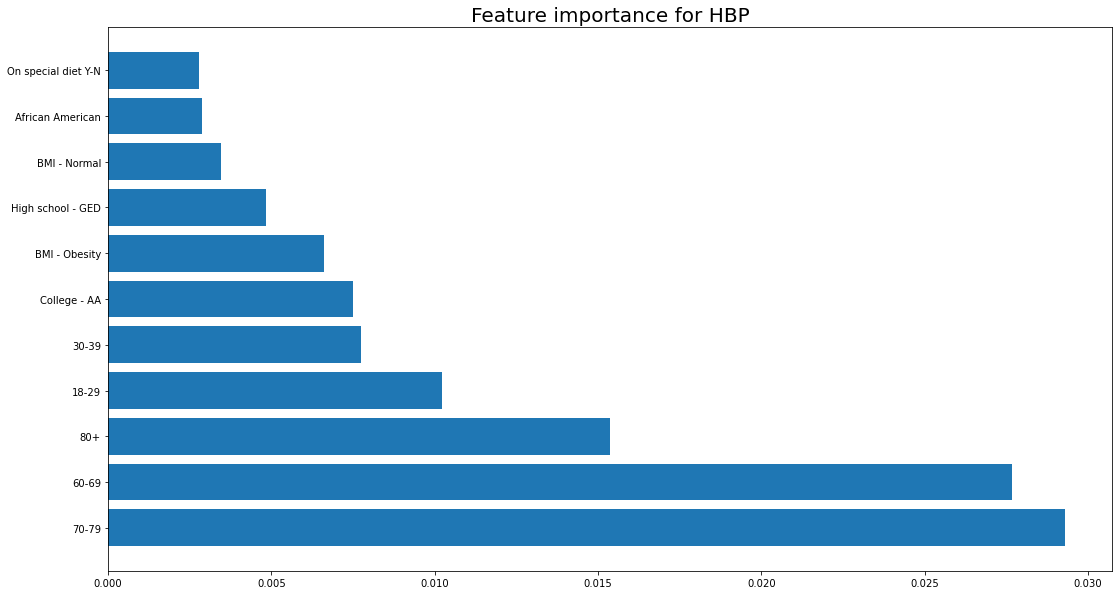

In [27]:
plot_features(NHANES_2013_2018_predictions, 
              'HBP', 
              'All features', 
              'LRC feature name', 
              'LRC feature importance')

In [28]:
models_scores_HCL['Accuracy']

LRC    0.811674
SVM    0.802863
DTC    0.807269
RFC    0.808737
GNB    0.628120
Name: Accuracy, dtype: float64

In [29]:
max(models_scores_HCL['Accuracy'])

0.8116740088105727

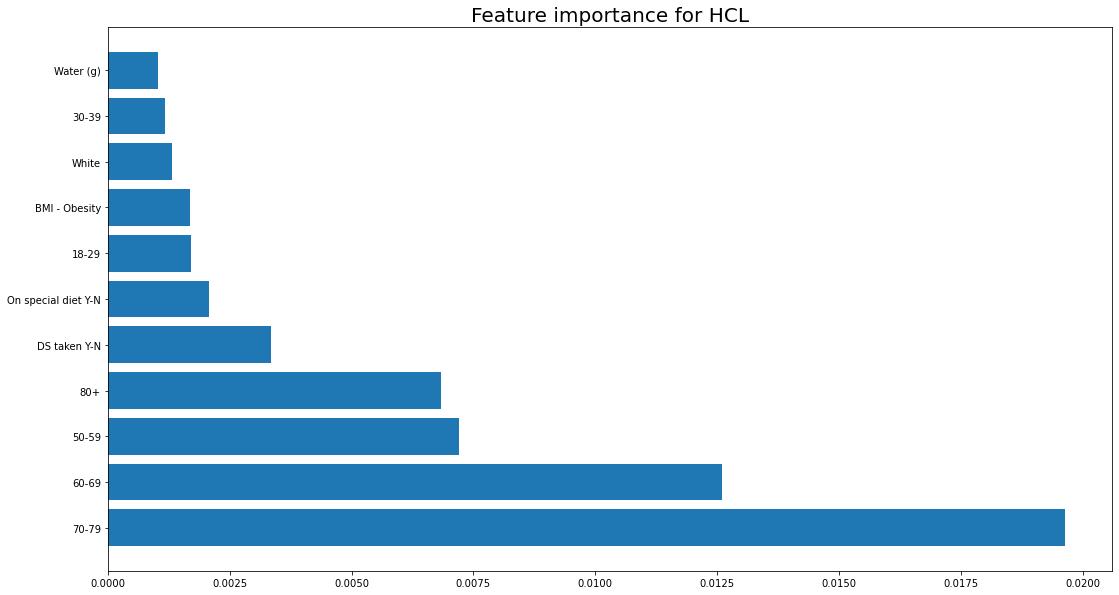

In [30]:
plot_features(NHANES_2013_2018_predictions, 
              'HCL', 
              'All features', 
              'LRC feature name', 
              'LRC feature importance')

In [31]:
models_scores_Diabetes['Accuracy']

LRC    0.860499
SVM    0.865272
DTC    0.865272
RFC    0.867841
GNB    0.455213
Name: Accuracy, dtype: float64

In [32]:
max(models_scores_Diabetes['Accuracy'])

0.8678414096916299

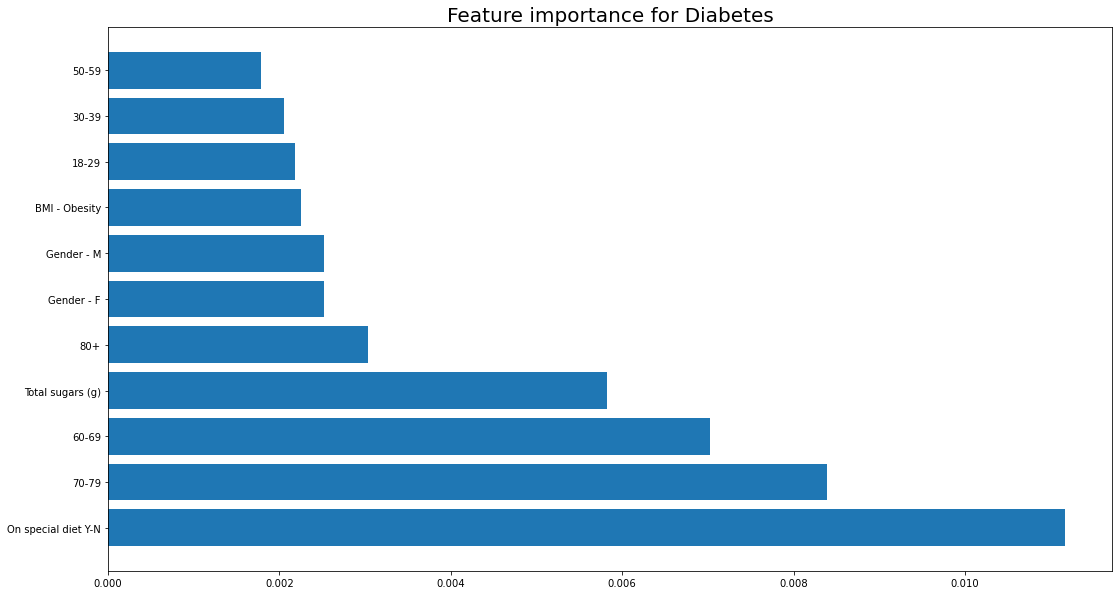

In [33]:
plot_features(NHANES_2013_2018_predictions, 
              'Diabetes', 
              'All features', 
              'LRC feature name', 
              'LRC feature importance')

Logistic Regression is the model better performing for the three health conditions.

If all the features are considered together, **age is the factor mostly influencing all the three conditions.**

# PART 2

The features are split by considering demographic, dietary, and lifestyle information.

### Modeling

The NHANES_2013_2018 DataFrame is 
- split into 4 DataFrames: Demographic, Dietary, Lifestyle, and Substances; 
- each of the 4 DataFrames are split in three parts, for each of the three healh conditions considered here.
The features are also scaled, and the datasets are split into training and testing sets.

In [34]:
NHANES_2013_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10895 entries, 0 to 10894
Data columns (total 85 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Have HBP                               10895 non-null  float64
 1   Have HCL                               10895 non-null  float64
 2   Have diabetes                          10895 non-null  float64
 3   Gender - F                             10895 non-null  int64  
 4   Gender - M                             10895 non-null  int64  
 5   Mexican American                       10895 non-null  int64  
 6   African American                       10895 non-null  int64  
 7   White                                  10895 non-null  int64  
 8   Other Hispanic                         10895 non-null  int64  
 9   Other / Multi-Racial                   10895 non-null  int64  
 10  Less than 9th grade                    10895 non-null  int64  
 11  9-

In [36]:
# Demographic DataFrame

demo_list = ['Have HBP',                               
             'Have HCL',                               
             'Have diabetes',                          
             'Gender - F',                             
             'Gender - M',                             
             'Mexican American',                       
             'African American',                       
             'White',                                  
             'Other Hispanic',                         
             'Other / Multi-Racial',                           
             'Less than 9th grade',                    
             '9-11th grade',                           
             'High school - GED',                      
             'College - AA',                           
             'College or above',                                                  
             '18-29',                              
             '30-39',                              
             '40-49',                              
             '50-59',                              
             '60-69',                              
             '70-79',                              
             '80+',
             'Num family members',
             'Under \$20,000',                         
             '$20,000 and Over',                         
             '$0 to \$4,999',                            
             '$5,000 to \$9,999',                        
             '$10,000 to \$14,999',                      
             '$15,000 to \$19,999',                      
             '$20,000 to \$24,999',                      
             '$25,000 to \$34,999',                      
             '$35,000 to \$44,999',                      
             '$45,000 to \$54,999',                      
             '$55,000 to \$64,999',                      
             '$65,000 to \$74,999',                      
             '$75,000 to \$99,999',                      
             '$100,000 and Over'
             
            ]
Demographic_df = NHANES_2013_2018[demo_list]

In [37]:
demo_no_conditions = Demographic_df.drop(['Have HBP', 'Have HCL', 'Have diabetes'], axis=1)

In [38]:
demo_no_conditions.shape

(10895, 34)

In [39]:
# Dietary DataFrame
diet_list = ['Have HBP',                               
             'Have HCL',                               
             'Have diabetes',
             'BMI - Underweight',                      
             'BMI - Normal',                           
             'BMI - Overweight',                       
             'BMI - Obesity',                          
             'DASH',                                   
             'Mediterranean',                          
             'Paleo',                                  
             'USDA Balanced',                          
             'Unbalanced',                             
             'On special diet Y-N',                    
             'Total sugars (g)',                       
             'Cholesterol (mg)',                       
             'Moisture (g)',                           
             'Water (g)',                              
             'Shellfish past 30 days Y-N',             
             'Fish past 30 days Y-N', 
            ]

Dietary_df = NHANES_2013_2018[diet_list]

In [40]:
diet_no_conditions = Dietary_df.drop(['Have HBP', 'Have HCL', 'Have diabetes'], axis=1)

In [41]:
diet_no_conditions.shape

(10895, 16)

In [42]:
# Lifestyle - Daily habits
lifestyle_df = ['Have HBP',                               
                'Have HCL',                               
                'Have diabetes',
                'Num days/week physical activity',        
                'Hours/day sedentary activity',           
                'DS taken Y-N',                           
                'Num DS taken daily',                     
                '\$ spent supermarket/grocery store',     
                '\$ spent for food at other stores',      
                '\$ spent eating out',                    
                '\$ spent carryout/delivered foods',      
                'Num meals not home prepared',            
                'Num meals from fast food',               
                'Num ready-to-eat foods',                 
                'Num frozen meals',
               ]

Lifestyle_df = NHANES_2013_2018[lifestyle_df]

In [43]:
life_no_conditions = Lifestyle_df.drop(['Have HBP', 'Have HCL', 'Have diabetes'], axis=1)

In [44]:
life_no_conditions.shape

(10895, 12)

In [45]:
# Lifestyle - Substances use or abuse
subs_list = ['Have HBP',                               
             'Have HCL',                               
             'Have diabetes',
             'Num cigs/day',                           
             'Alcohol drinks/day',                     
             '4+ drinks every day Y-N',               
             'Marijuana - Once per month',             
             'Marijuana - 2-3 times per month',        
             'Marijuana - 1-2 times per week',         
             'Marijuana - 3-6 times per week',         
             'Marijuana - one or more times per day',  
             'Cocaine - Once',                         
             'Cocaine - 2-5 times',                    
             'Cocaine - 6-19 times',                   
             'Cocaine - 20-49 times',                  
             'Cocaine - 50-99 times',                  
             'Cocaine - >100 times',                   
             'Meth - Once',                            
             'Meth - 2-5 times',                       
             'Meth - 6-19 times',                      
             'Meth - 20-49 times',                     
             'Meth - 50-99 times',                     
             'Meth - >100 times'
            ]

Substances_df = NHANES_2013_2018[subs_list]

In [46]:
subs_no_conditions = Substances_df.drop(['Have HBP', 'Have HCL', 'Have diabetes'], axis=1)

In [47]:
subs_no_conditions.shape

(10895, 20)

## High Blood Pressure

### Demographic Category

In [48]:
features_names_HBP_demo, \
feat_importance_HBP_demo, \
models_scores_HBP_demo = feature_importance(health_df = Demographic_df, 
                                       col1 = 'Have HCL', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HBP', 
                                       category = 'Demographic', 
                                       condition = 'HBP', 
                                       no_conditions_df = demo_no_conditions, 
                                       save = False)


LRC
SVM
DTC
RFC
GNB


In [49]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HBP_demo, 
              feat_importance_HBP_demo,
              models_scores_HBP_demo,
              'HBP',
              'Demographic'
             )

In [50]:
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [52]:
NHANES_2013_2018_predictions.tail(34)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
246,HBP,Demographic,60-69,0.030963,0.76395,60-69,0.087651,0.748164,30-39,0.331526,0.748164,18-29,0.169888,0.758443,18-29,0.043202,0.729809
247,HBP,Demographic,70-79,0.025285,0.76395,70-79,0.063199,0.748164,18-29,0.304143,0.748164,60-69,0.159136,0.758443,30-39,0.027928,0.729809
248,HBP,Demographic,80+,0.014319,0.76395,80+,0.034121,0.748164,40-49,0.248186,0.748164,70-79,0.143479,0.758443,70-79,0.020389,0.729809
249,HBP,Demographic,30-39,0.006486,0.76395,"$65,000 to \$74,999",0.0,0.748164,50-59,0.116145,0.748164,30-39,0.120237,0.758443,40-49,0.011455,0.729809
250,HBP,Demographic,18-29,0.006242,0.76395,"$55,000 to \$64,999",0.0,0.748164,Gender - F,0.0,0.748164,Num family members,0.08152,0.758443,80+,0.009546,0.729809
251,HBP,Demographic,African American,0.004822,0.76395,"$45,000 to \$54,999",0.0,0.748164,"$10,000 to \$14,999",0.0,0.748164,80+,0.073406,0.758443,60-69,0.005434,0.729809
252,HBP,Demographic,Other Hispanic,0.002374,0.76395,"$35,000 to \$44,999",0.0,0.748164,"$20,000 and Over",0.0,0.748164,40-49,0.038668,0.758443,African American,0.003623,0.729809
253,HBP,Demographic,50-59,0.002301,0.76395,"$25,000 to \$34,999",0.0,0.748164,"$0 to \$4,999",0.0,0.748164,50-59,0.037079,0.758443,Mexican American,0.002962,0.729809
254,HBP,Demographic,Mexican American,0.002252,0.76395,"$20,000 to \$24,999",0.0,0.748164,"$5,000 to \$9,999",0.0,0.748164,African American,0.031512,0.758443,Other Hispanic,0.002741,0.729809
255,HBP,Demographic,"$35,000 to \$44,999",0.002056,0.76395,"$15,000 to \$19,999",0.0,0.748164,"$15,000 to \$19,999",0.0,0.748164,College or above,0.020767,0.758443,"Under \$20,000",0.002668,0.729809


In [53]:
print(models_scores_HBP_demo['Accuracy'])
print(max(models_scores_HBP_demo['Accuracy']))

LRC    0.763950
SVM    0.748164
DTC    0.748164
RFC    0.758443
GNB    0.729809
Name: Accuracy, dtype: float64
0.7639500734214391


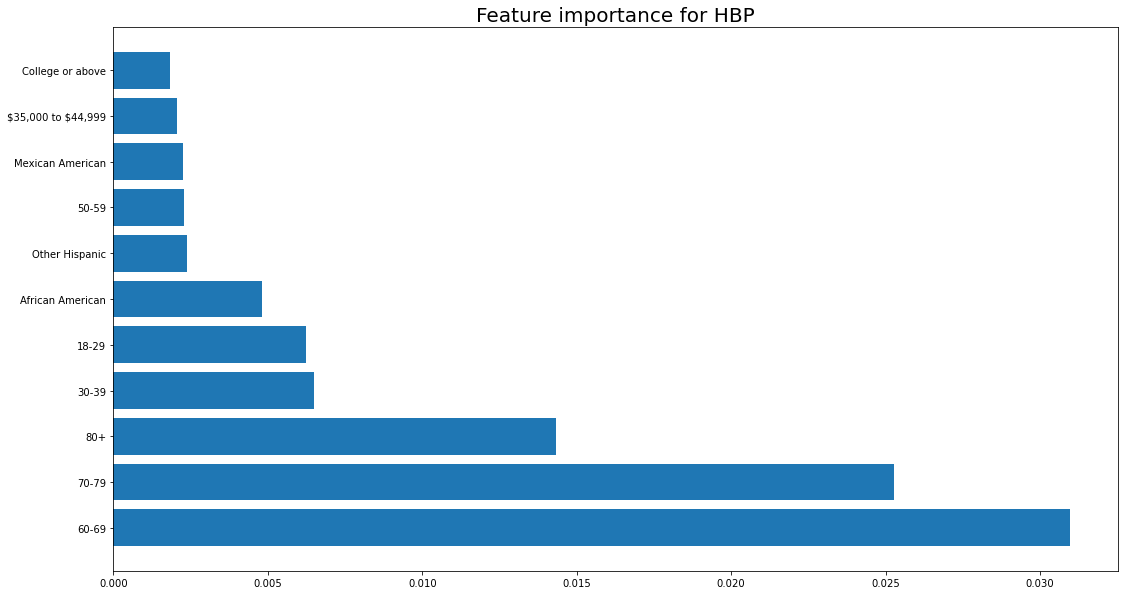

In [54]:
plot_features(NHANES_2013_2018_predictions, 'HBP', 'Demographic', 'LRC feature name', 'LRC feature importance')

## Dietary category

In [55]:
features_names_HBP_diet, \
feat_importance_HBP_diet, \
models_scores_HBP_diet = feature_importance(health_df = Dietary_df, 
                                       col1 = 'Have HCL', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HBP', 
                                       category = 'Dietary', 
                                       condition = 'HBP', 
                                       no_conditions_df = diet_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GNB


In [56]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HBP_diet, 
              feat_importance_HBP_diet,
              models_scores_HBP_diet,
              'HBP',
              'Dietary'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [57]:
NHANES_2013_2018_predictions.tail(16)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
280,HBP,Dietary,On special diet Y-N,0.006144,0.731278,BMI - Underweight,0.0,0.733847,BMI - Normal,0.51822,0.733847,Total sugars (g),0.176571,0.734949,Total sugars (g),0.009448,0.624816
281,HBP,Dietary,BMI - Obesity,0.004406,0.731278,BMI - Normal,0.0,0.733847,On special diet Y-N,0.209114,0.733847,Water (g),0.163557,0.734949,On special diet Y-N,0.008322,0.624816
282,HBP,Dietary,Water (g),0.003402,0.731278,BMI - Overweight,0.0,0.733847,BMI - Obesity,0.088865,0.733847,Moisture (g),0.158343,0.734949,Fish past 30 days Y-N,0.006462,0.624816
283,HBP,Dietary,Fish past 30 days Y-N,0.002521,0.731278,BMI - Obesity,0.0,0.733847,Fish past 30 days Y-N,0.083469,0.733847,Cholesterol (mg),0.153686,0.734949,BMI - Normal,0.004283,0.624816
284,HBP,Dietary,Total sugars (g),0.001885,0.731278,DASH,0.0,0.733847,Water (g),0.050351,0.733847,BMI - Normal,0.096011,0.734949,USDA Balanced,0.001469,0.624816
285,HBP,Dietary,Unbalanced,0.001713,0.731278,Mediterranean,0.0,0.733847,Moisture (g),0.049982,0.733847,BMI - Obesity,0.072173,0.734949,BMI - Underweight,0.00115,0.624816
286,HBP,Dietary,BMI - Overweight,0.00115,0.731278,Paleo,0.0,0.733847,BMI - Underweight,0.0,0.733847,On special diet Y-N,0.047232,0.734949,Paleo,0.000955,0.624816
287,HBP,Dietary,Moisture (g),0.001101,0.731278,USDA Balanced,0.0,0.733847,BMI - Overweight,0.0,0.733847,Fish past 30 days Y-N,0.03548,0.734949,DASH,0.000832,0.624816
288,HBP,Dietary,BMI - Normal,0.000636,0.731278,Unbalanced,0.0,0.733847,DASH,0.0,0.733847,BMI - Overweight,0.025677,0.734949,Shellfish past 30 days Y-N,0.000661,0.624816
289,HBP,Dietary,Cholesterol (mg),0.000514,0.731278,On special diet Y-N,0.0,0.733847,Mediterranean,0.0,0.733847,Shellfish past 30 days Y-N,0.021463,0.734949,Mediterranean,0.00049,0.624816


In [58]:
print(models_scores_HBP_diet['Accuracy'])
print(max(models_scores_HBP_diet['Accuracy']))

LRC    0.731278
SVM    0.733847
DTC    0.733847
RFC    0.734949
GNB    0.624816
Name: Accuracy, dtype: float64
0.7349486049926579


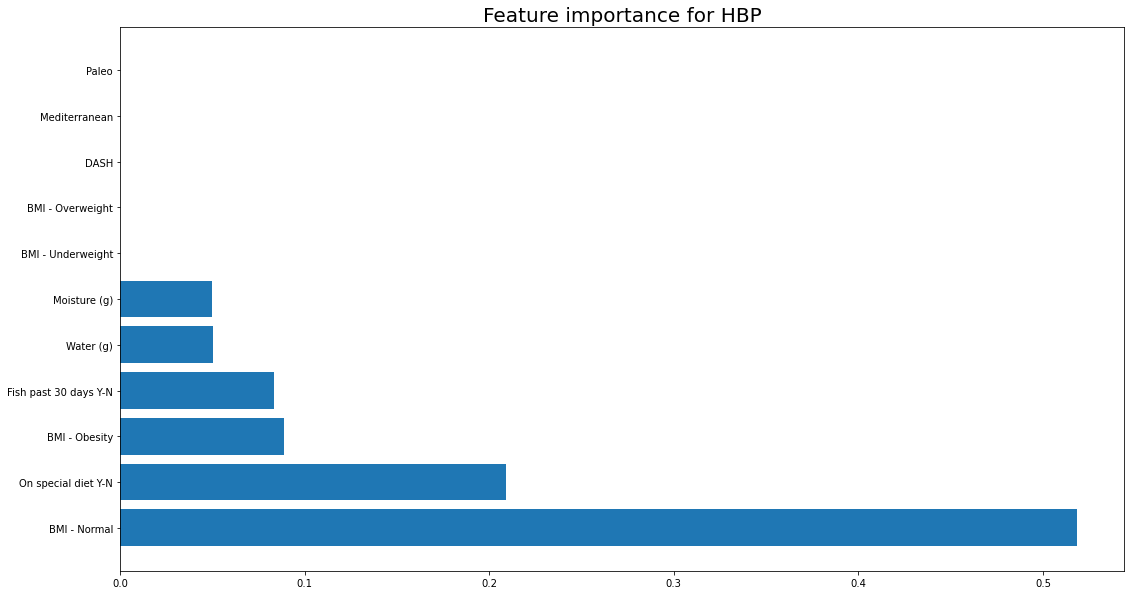

In [59]:
plot_features(NHANES_2013_2018_predictions, 'HBP', 'Dietary', 'DTC feature name', 'DTC feature importance')

## Lifestyle category

In [60]:
features_names_HBP_life, \
feat_importance_HBP_life, \
models_scores_HBP_life = feature_importance(health_df = Lifestyle_df, 
                                       col1 = 'Have HCL', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HBP', 
                                       category = 'Lifestyle', 
                                       condition = 'HBP', 
                                       no_conditions_df = life_no_conditions, 
                                       save = False)

LRC
SVM
DTC
RFC
GNB


In [61]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HBP_life, 
              feat_importance_HBP_life,
              models_scores_HBP_life,
              'HBP',
              'Lifestyle'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [62]:
NHANES_2013_2018_predictions.tail(12)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
296,HBP,Lifestyle,DS taken Y-N,0.005165,0.735316,Num days/week physical activity,0.0,0.733113,DS taken Y-N,0.356793,0.727606,Num days/week physical activity,0.160905,0.734581,DS taken Y-N,0.017746,0.664097
297,HBP,Lifestyle,Num days/week physical activity,0.004283,0.735316,Hours/day sedentary activity,0.0,0.733113,Num days/week physical activity,0.283426,0.727606,\$ spent eating out,0.157701,0.734581,Num days/week physical activity,0.014123,0.664097
298,HBP,Lifestyle,\$ spent eating out,0.002448,0.735316,DS taken Y-N,0.0,0.733113,\$ spent eating out,0.228213,0.727606,\$ spent supermarket/grocery store,0.123191,0.734581,\$ spent for food at other stores,0.002962,0.664097
299,HBP,Lifestyle,\$ spent for food at other stores,0.001787,0.735316,Num DS taken daily,0.0,0.733113,\$ spent supermarket/grocery store,0.054277,0.727606,Num DS taken daily,0.099877,0.734581,\$ spent supermarket/grocery store,0.001713,0.664097
300,HBP,Lifestyle,\$ spent supermarket/grocery store,0.001615,0.735316,\$ spent supermarket/grocery store,0.0,0.733113,\$ spent for food at other stores,0.039052,0.727606,\$ spent for food at other stores,0.086042,0.734581,\$ spent eating out,0.000587,0.664097
301,HBP,Lifestyle,Num frozen meals,0.001248,0.735316,\$ spent for food at other stores,0.0,0.733113,Num DS taken daily,0.038239,0.727606,Hours/day sedentary activity,0.07758,0.734581,Num DS taken daily,0.000098,0.664097
302,HBP,Lifestyle,Num ready-to-eat foods,0.001175,0.735316,\$ spent eating out,0.0,0.733113,Hours/day sedentary activity,0.0,0.727606,DS taken Y-N,0.061165,0.734581,Hours/day sedentary activity,-0.000563,0.664097
303,HBP,Lifestyle,Num meals from fast food,0.001004,0.735316,\$ spent carryout/delivered foods,0.0,0.733113,\$ spent carryout/delivered foods,0.0,0.727606,Num meals not home prepared,0.057983,0.734581,Num ready-to-eat foods,-0.000783,0.664097
304,HBP,Lifestyle,Num meals not home prepared,0.000636,0.735316,Num meals not home prepared,0.0,0.733113,Num meals not home prepared,0.0,0.727606,\$ spent carryout/delivered foods,0.050106,0.734581,Num frozen meals,-0.002888,0.664097
305,HBP,Lifestyle,Num DS taken daily,0.000245,0.735316,Num meals from fast food,0.0,0.733113,Num meals from fast food,0.0,0.727606,Num meals from fast food,0.046807,0.734581,\$ spent carryout/delivered foods,-0.004577,0.664097


In [63]:
print(models_scores_HBP_life['Accuracy'])
print(max(models_scores_HBP_life['Accuracy']))

LRC    0.735316
SVM    0.733113
DTC    0.727606
RFC    0.734581
GNB    0.664097
Name: Accuracy, dtype: float64
0.7353157121879589


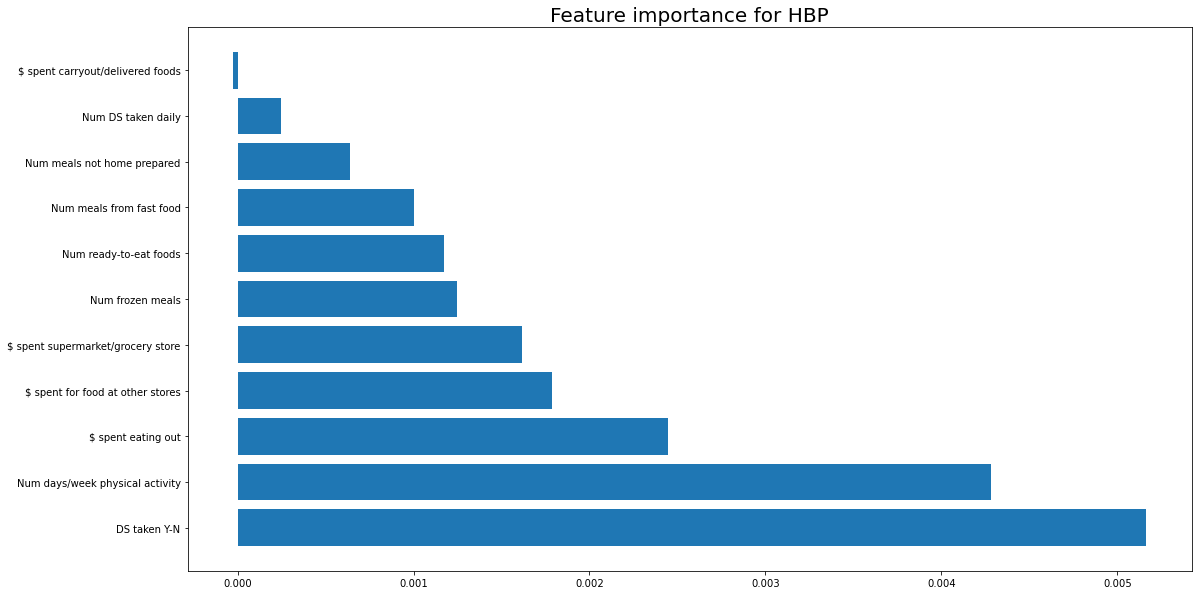

In [64]:
plot_features(NHANES_2013_2018_predictions, 'HBP', 'Lifestyle', 'LRC feature name', 'LRC feature importance')

## Lifestyle - Substances

In [65]:
features_names_HBP_subs, \
feat_importance_HBP_subs, \
models_scores_HBP_subs = feature_importance(health_df = Substances_df, 
                                       col1 = 'Have HCL', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HBP', 
                                       category = 'Substances', 
                                       condition = 'HBP', 
                                       no_conditions_df = subs_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HBP_subs, 
              feat_importance_HBP_subs,
              models_scores_HBP_subs,
              'HBP',
              'Substances'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [67]:
NHANES_2013_2018_predictions.tail(20)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
308,HBP,Substances,4+ drinks every day Y-N,0.014246,0.731278,Num cigs/day,0.0,0.733847,Alcohol drinks/day,1.0,0.733847,Alcohol drinks/day,0.30677,0.729075,Marijuana - 3-6 times per week,0.004675,0.413363
309,HBP,Substances,Alcohol drinks/day,0.005825,0.731278,Meth - 20-49 times,0.0,0.733847,Num cigs/day,0.0,0.733847,Num cigs/day,0.150499,0.729075,Marijuana - one or more times per day,0.003941,0.413363
310,HBP,Substances,Marijuana - one or more times per day,0.001713,0.731278,Meth - 6-19 times,0.0,0.733847,Meth - 50-99 times,0.0,0.733847,4+ drinks every day Y-N,0.116135,0.729075,Marijuana - 1-2 times per week,0.003549,0.413363
311,HBP,Substances,Marijuana - 3-6 times per week,0.000563,0.731278,Meth - 2-5 times,0.0,0.733847,Meth - 20-49 times,0.0,0.733847,Marijuana - one or more times per day,0.082351,0.729075,Marijuana - 2-3 times per month,0.003133,0.413363
312,HBP,Substances,Cocaine - 2-5 times,0.000514,0.731278,Meth - Once,0.0,0.733847,Meth - 6-19 times,0.0,0.733847,Marijuana - 3-6 times per week,0.068564,0.729075,Cocaine - Once,0.001738,0.413363
313,HBP,Substances,Marijuana - Once per month,0.000441,0.731278,Cocaine - >100 times,0.0,0.733847,Meth - 2-5 times,0.0,0.733847,Cocaine - 2-5 times,0.039155,0.729075,Marijuana - Once per month,0.00142,0.413363
314,HBP,Substances,Marijuana - 1-2 times per week,0.000441,0.731278,Cocaine - 50-99 times,0.0,0.733847,Meth - Once,0.0,0.733847,Marijuana - 1-2 times per week,0.031764,0.729075,Alcohol drinks/day,0.000392,0.413363
315,HBP,Substances,Cocaine - Once,0.000318,0.731278,Cocaine - 20-49 times,0.0,0.733847,Cocaine - >100 times,0.0,0.733847,Cocaine - >100 times,0.025371,0.729075,4+ drinks every day Y-N,-0.000122,0.413363
316,HBP,Substances,Num cigs/day,0.000171,0.731278,Cocaine - 6-19 times,0.0,0.733847,Cocaine - 50-99 times,0.0,0.733847,Cocaine - Once,0.025301,0.729075,Num cigs/day,-0.000196,0.413363
317,HBP,Substances,Meth - 20-49 times,0.000147,0.731278,Cocaine - 2-5 times,0.0,0.733847,Cocaine - 20-49 times,0.0,0.733847,Cocaine - 20-49 times,0.023156,0.729075,Meth - Once,-0.000808,0.413363


In [68]:
print(models_scores_HBP_subs['Accuracy'])
print(max(models_scores_HBP_subs['Accuracy']))

LRC    0.731278
SVM    0.733847
DTC    0.733847
RFC    0.729075
GNB    0.413363
Name: Accuracy, dtype: float64
0.7338472834067548


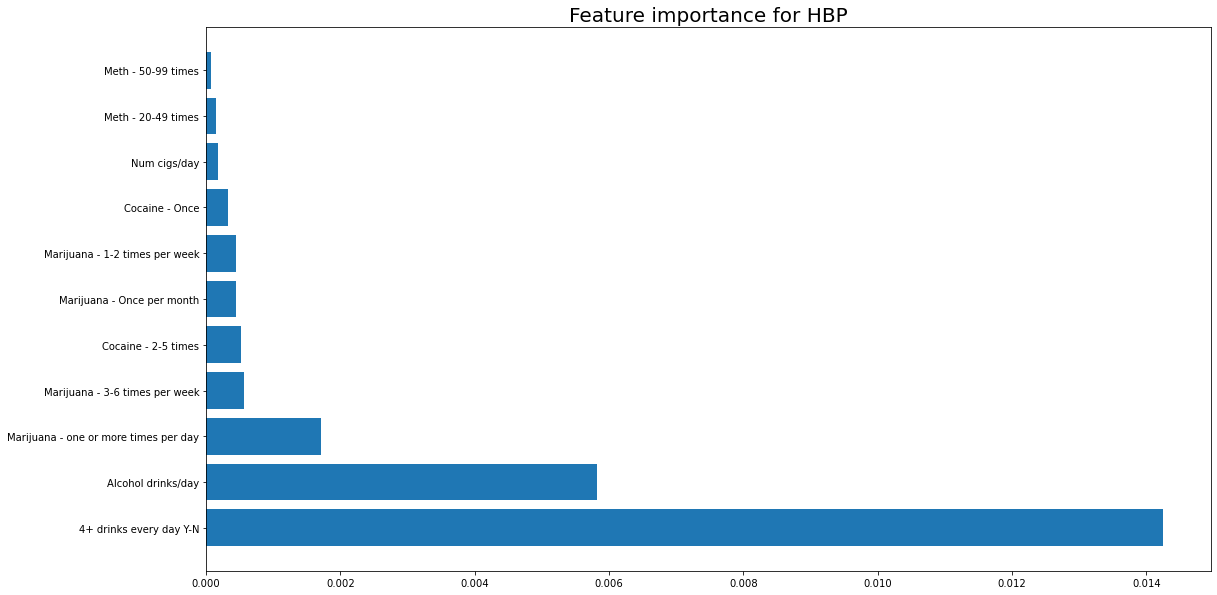

In [69]:
plot_features(NHANES_2013_2018_predictions, 'HBP', 'Substances', 'LRC feature name', 'LRC feature importance')

## High Cholesterol Level

### Demographic Category

In [70]:
features_names_HCL_demo, \
feat_importance_HCL_demo, \
models_scores_HCL_demo = feature_importance(health_df = Demographic_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HCL', 
                                       category = 'Demographic', 
                                       condition = 'HCL', 
                                       no_conditions_df = demo_no_conditions, 
                                       save = False)


LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HCL_demo, 
              feat_importance_HCL_demo,
              models_scores_HCL_demo,
              'HCL',
              'Demographic'
             )

In [72]:
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [73]:
NHANES_2013_2018_predictions.tail(34)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
328,HCL,Demographic,70-79,0.01848,0.810206,Gender - F,0.0,0.802863,18-29,1.0,0.802863,18-29,0.140954,0.803965,18-29,0.061412,0.682085
329,HCL,Demographic,60-69,0.016791,0.810206,"$65,000 to \$74,999",0.0,0.802863,Gender - F,0.0,0.802863,70-79,0.132088,0.803965,30-39,0.049419,0.682085
330,HCL,Demographic,50-59,0.008469,0.810206,"$55,000 to \$64,999",0.0,0.802863,"$15,000 to \$19,999",0.0,0.802863,30-39,0.12091,0.803965,40-49,0.039359,0.682085
331,HCL,Demographic,80+,0.00656,0.810206,"$45,000 to \$54,999",0.0,0.802863,"Under \$20,000",0.0,0.802863,Num family members,0.115844,0.803965,70-79,0.011137,0.682085
332,HCL,Demographic,Other / Multi-Racial,0.00279,0.810206,"$35,000 to \$44,999",0.0,0.802863,"$20,000 and Over",0.0,0.802863,60-69,0.092555,0.803965,80+,0.007221,0.682085
333,HCL,Demographic,African American,0.001615,0.810206,"$25,000 to \$34,999",0.0,0.802863,"$0 to \$4,999",0.0,0.802863,40-49,0.053855,0.803965,"$0 to \$4,999",0.004283,0.682085
334,HCL,Demographic,Gender - F,0.001493,0.810206,"$20,000 to \$24,999",0.0,0.802863,"$5,000 to \$9,999",0.0,0.802863,80+,0.044103,0.803965,"Under \$20,000",0.00142,0.682085
335,HCL,Demographic,Gender - M,0.001493,0.810206,"$15,000 to \$19,999",0.0,0.802863,"$10,000 to \$14,999",0.0,0.802863,50-59,0.034228,0.803965,Gender - F,0.000857,0.682085
336,HCL,Demographic,"$75,000 to \$99,999",0.001175,0.810206,"$10,000 to \$14,999",0.0,0.802863,"$20,000 to \$24,999",0.0,0.802863,Gender - M,0.017933,0.803965,Gender - M,0.000857,0.682085
337,HCL,Demographic,"$55,000 to \$64,999",0.001077,0.810206,"$5,000 to \$9,999",0.0,0.802863,80+,0.0,0.802863,College or above,0.017492,0.803965,White,0.000636,0.682085


In [74]:
print(models_scores_HCL_demo['Accuracy'])
print(max(models_scores_HCL_demo['Accuracy']))

LRC    0.810206
SVM    0.802863
DTC    0.802863
RFC    0.803965
GNB    0.682085
Name: Accuracy, dtype: float64
0.8102055800293686


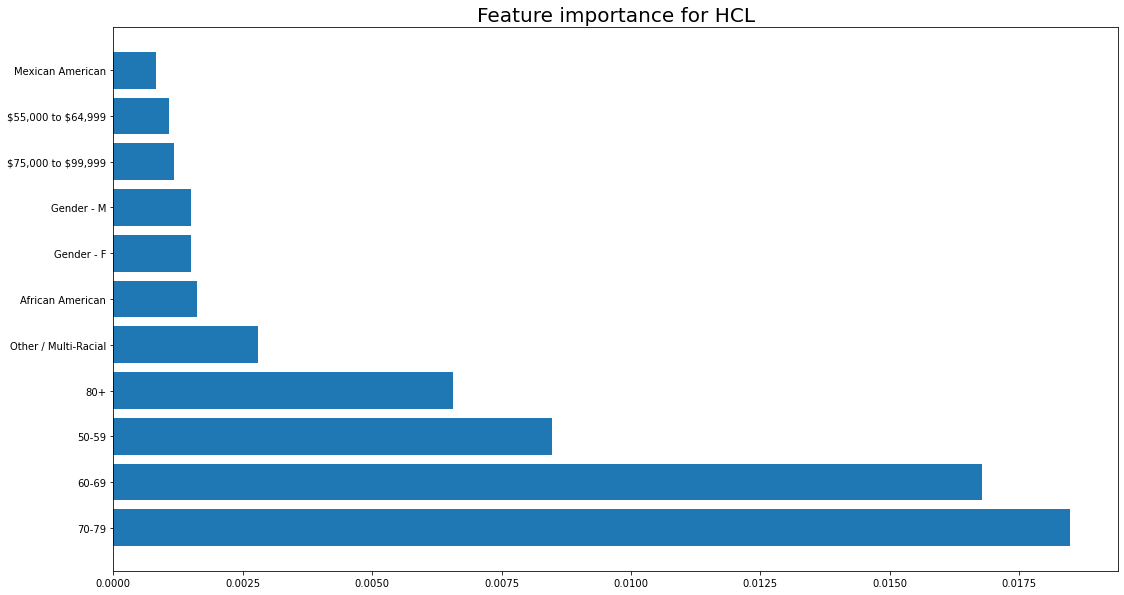

In [75]:
plot_features(NHANES_2013_2018_predictions, 'HCL', 'Demographic', 'LRC feature name', 'LRC feature importance')

## Dietary category

In [76]:
features_names_HCL_diet, \
feat_importance_HCL_diet, \
models_scores_HCL_diet = feature_importance(health_df = Dietary_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HCL', 
                                       category = 'Dietary', 
                                       condition = 'HCL', 
                                       no_conditions_df = diet_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HCL_diet, 
              feat_importance_HCL_diet,
              models_scores_HCL_diet,
              'HCL',
              'Dietary'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [78]:
NHANES_2013_2018_predictions.tail(16)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
362,HCL,Dietary,Water (g),0.00257,0.803598,BMI - Underweight,0.0,0.802863,On special diet Y-N,1.0,0.802863,Total sugars (g),0.205407,0.802496,On special diet Y-N,0.014025,0.602056
363,HCL,Dietary,Moisture (g),0.001175,0.803598,BMI - Normal,0.0,0.802863,BMI - Underweight,0.0,0.802863,Water (g),0.200127,0.802496,Fish past 30 days Y-N,0.003525,0.602056
364,HCL,Dietary,BMI - Obesity,0.00022,0.803598,BMI - Overweight,0.0,0.802863,BMI - Normal,0.0,0.802863,Moisture (g),0.190007,0.802496,BMI - Normal,0.002888,0.602056
365,HCL,Dietary,Fish past 30 days Y-N,0.000196,0.803598,BMI - Obesity,0.0,0.802863,BMI - Overweight,0.0,0.802863,Cholesterol (mg),0.17242,0.802496,Total sugars (g),0.002056,0.602056
366,HCL,Dietary,BMI - Overweight,0.000122,0.803598,DASH,0.0,0.802863,BMI - Obesity,0.0,0.802863,On special diet Y-N,0.052682,0.802496,Paleo,0.001053,0.602056
367,HCL,Dietary,Mediterranean,0.000122,0.803598,Mediterranean,0.0,0.802863,DASH,0.0,0.802863,BMI - Normal,0.034163,0.802496,BMI - Underweight,0.001028,0.602056
368,HCL,Dietary,Cholesterol (mg),0.000122,0.803598,Paleo,0.0,0.802863,Mediterranean,0.0,0.802863,Shellfish past 30 days Y-N,0.025217,0.802496,USDA Balanced,0.000367,0.602056
369,HCL,Dietary,Total sugars (g),0.000098,0.803598,USDA Balanced,0.0,0.802863,Paleo,0.0,0.802863,Fish past 30 days Y-N,0.024739,0.802496,Unbalanced,0.000171,0.602056
370,HCL,Dietary,Unbalanced,0.000073,0.803598,Unbalanced,0.0,0.802863,USDA Balanced,0.0,0.802863,BMI - Obesity,0.023403,0.802496,DASH,0.000122,0.602056
371,HCL,Dietary,USDA Balanced,0.000024,0.803598,On special diet Y-N,0.0,0.802863,Unbalanced,0.0,0.802863,Unbalanced,0.016284,0.802496,Mediterranean,-0.000122,0.602056


In [79]:
print(models_scores_HCL_diet['Accuracy'])
print(max(models_scores_HCL_diet['Accuracy']))

LRC    0.803598
SVM    0.802863
DTC    0.802863
RFC    0.802496
GNB    0.602056
Name: Accuracy, dtype: float64
0.80359765051395


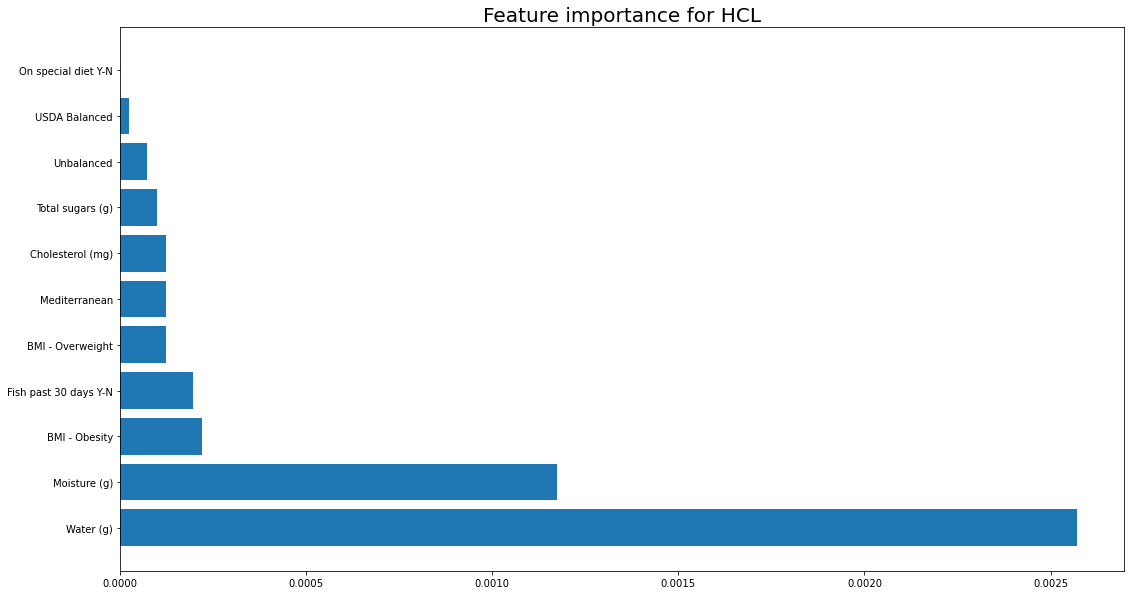

In [80]:
plot_features(NHANES_2013_2018_predictions, 'HCL', 'Dietary', 'LRC feature name', 'LRC feature importance')

## Lifestyle category

In [81]:
features_names_HCL_life, \
feat_importance_HCL_life, \
models_scores_HCL_life = feature_importance(health_df = Lifestyle_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HCL', 
                                       category = 'Lifestyle', 
                                       condition = 'HCL', 
                                       no_conditions_df = life_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HCL_life, 
              feat_importance_HCL_life,
              models_scores_HCL_life,
              'HCL',
              'Lifestyle'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [83]:
NHANES_2013_2018_predictions.tail(12)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
378,HCL,Lifestyle,DS taken Y-N,0.000049,0.802863,Num days/week physical activity,0.0,0.802863,DS taken Y-N,1.0,0.802863,Num days/week physical activity,0.122481,0.802863,DS taken Y-N,0.012459,0.43025
379,HCL,Lifestyle,Num days/week physical activity,0.0,0.802863,Hours/day sedentary activity,0.0,0.802863,Num days/week physical activity,0.0,0.802863,\$ spent supermarket/grocery store,0.117399,0.802863,Num days/week physical activity,0.010133,0.43025
380,HCL,Lifestyle,Hours/day sedentary activity,0.0,0.802863,DS taken Y-N,0.0,0.802863,Hours/day sedentary activity,0.0,0.802863,Num DS taken daily,0.107956,0.802863,\$ spent for food at other stores,0.005434,0.43025
381,HCL,Lifestyle,Num DS taken daily,0.0,0.802863,Num DS taken daily,0.0,0.802863,Num DS taken daily,0.0,0.802863,\$ spent eating out,0.10673,0.802863,Hours/day sedentary activity,0.00071,0.43025
382,HCL,Lifestyle,\$ spent supermarket/grocery store,0.0,0.802863,\$ spent supermarket/grocery store,0.0,0.802863,\$ spent supermarket/grocery store,0.0,0.802863,Hours/day sedentary activity,0.096464,0.802863,\$ spent supermarket/grocery store,-0.000269,0.43025
383,HCL,Lifestyle,\$ spent for food at other stores,0.0,0.802863,\$ spent for food at other stores,0.0,0.802863,\$ spent for food at other stores,0.0,0.802863,\$ spent for food at other stores,0.086657,0.802863,Num DS taken daily,-0.000294,0.43025
384,HCL,Lifestyle,\$ spent eating out,0.0,0.802863,\$ spent eating out,0.0,0.802863,\$ spent eating out,0.0,0.802863,\$ spent carryout/delivered foods,0.07045,0.802863,Num frozen meals,-0.000367,0.43025
385,HCL,Lifestyle,\$ spent carryout/delivered foods,0.0,0.802863,\$ spent carryout/delivered foods,0.0,0.802863,\$ spent carryout/delivered foods,0.0,0.802863,Num meals not home prepared,0.066297,0.802863,Num ready-to-eat foods,-0.000587,0.43025
386,HCL,Lifestyle,Num meals not home prepared,0.0,0.802863,Num meals not home prepared,0.0,0.802863,Num meals not home prepared,0.0,0.802863,DS taken Y-N,0.064099,0.802863,\$ spent eating out,-0.000612,0.43025
387,HCL,Lifestyle,Num meals from fast food,0.0,0.802863,Num meals from fast food,0.0,0.802863,Num meals from fast food,0.0,0.802863,Num frozen meals,0.056392,0.802863,Num meals from fast food,-0.00399,0.43025


In [84]:
print(models_scores_HCL_life['Accuracy'])
print(max(models_scores_HCL_life['Accuracy']))

LRC    0.802863
SVM    0.802863
DTC    0.802863
RFC    0.802863
GNB    0.430250
Name: Accuracy, dtype: float64
0.802863436123348


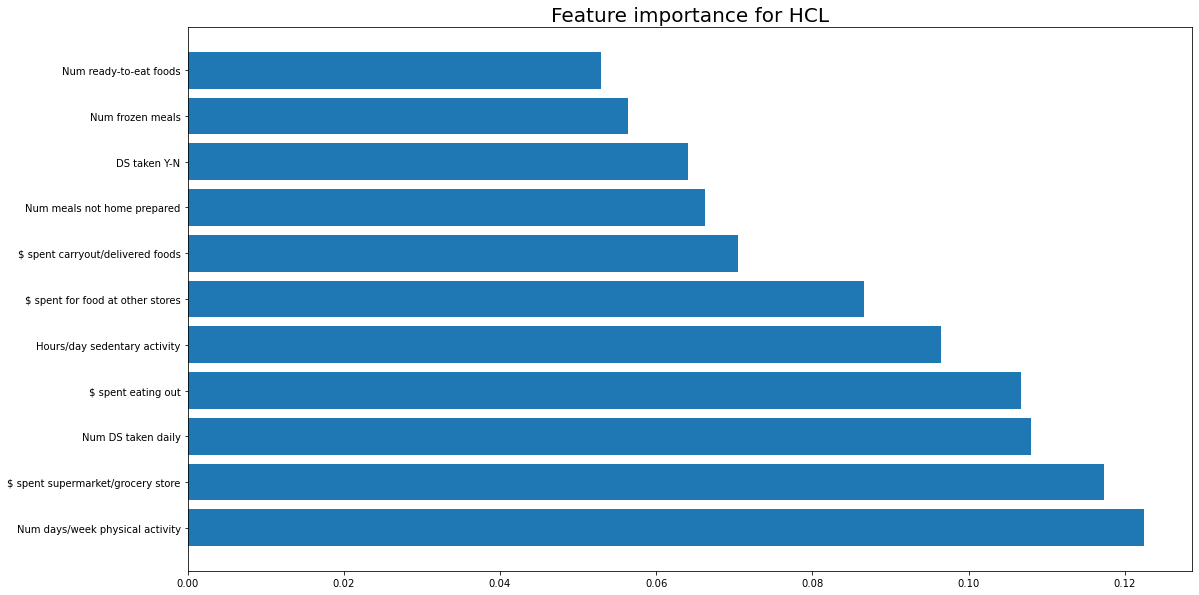

In [87]:
plot_features(NHANES_2013_2018_predictions, 'HCL', 'Lifestyle', 'RFC feature name', 'RFC feature importance')

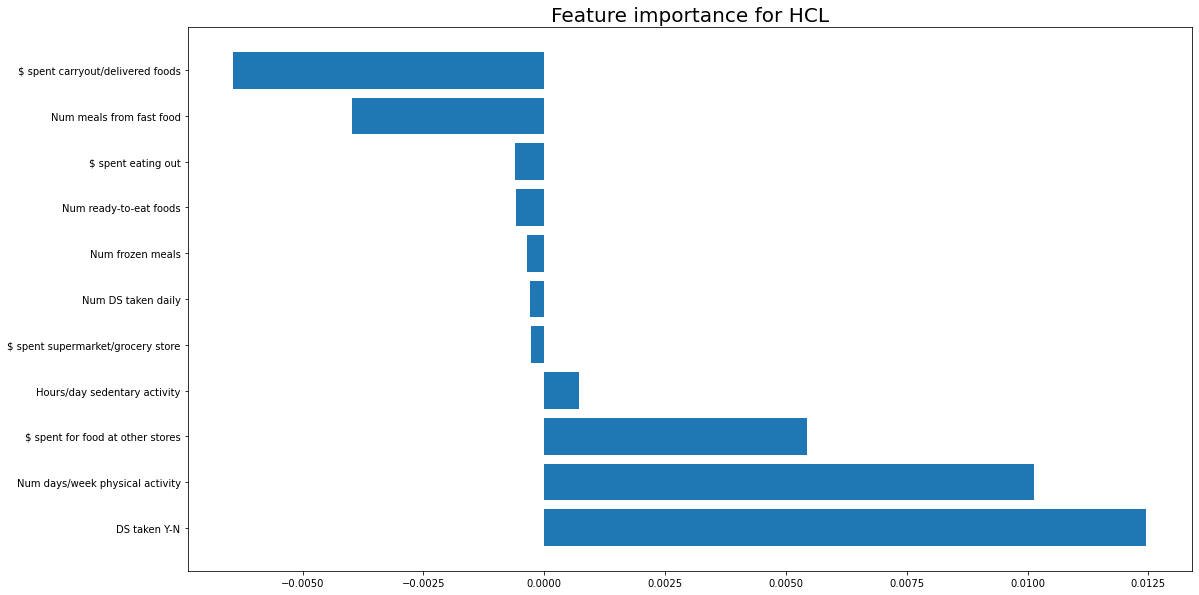

In [88]:
plot_features(NHANES_2013_2018_predictions, 'HCL', 'Lifestyle', 'GNB feature name', 'GNB feature importance')

## Lifestyle - Substances

In [89]:
features_names_HCL_subs, \
feat_importance_HCL_subs, \
models_scores_HCL_subs = feature_importance(health_df = Substances_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have diabetes', 
                                       col3 = 'Have HCL', 
                                       category = 'Substances', 
                                       condition = 'HCL', 
                                       no_conditions_df = subs_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_HCL_subs, 
              feat_importance_HCL_subs,
              models_scores_HCL_subs,
              'HCL',
              'Substances'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [91]:
NHANES_2013_2018_predictions.tail(20)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
390,HCL,Substances,Meth - 6-19 times,0.000367,0.802863,Num cigs/day,0.0,0.802863,Alcohol drinks/day,1.0,0.802863,Alcohol drinks/day,0.281784,0.802863,Marijuana - 1-2 times per week,0.003843,0.38069
391,HCL,Substances,Marijuana - one or more times per day,0.000294,0.802863,Meth - 20-49 times,0.0,0.802863,Num cigs/day,0.0,0.802863,Marijuana - one or more times per day,0.185705,0.802863,Marijuana - 2-3 times per month,0.002081,0.38069
392,HCL,Substances,4+ drinks every day Y-N,0.000196,0.802863,Meth - 6-19 times,0.0,0.802863,Meth - 50-99 times,0.0,0.802863,4+ drinks every day Y-N,0.081785,0.802863,Cocaine - Once,0.000661,0.38069
393,HCL,Substances,Alcohol drinks/day,0.000122,0.802863,Meth - 2-5 times,0.0,0.802863,Meth - 20-49 times,0.0,0.802863,Marijuana - 3-6 times per week,0.067351,0.802863,Alcohol drinks/day,0.000514,0.38069
394,HCL,Substances,Marijuana - 2-3 times per month,0.000122,0.802863,Meth - Once,0.0,0.802863,Meth - 6-19 times,0.0,0.802863,Marijuana - 1-2 times per week,0.063543,0.802863,Marijuana - Once per month,0.000318,0.38069
395,HCL,Substances,Marijuana - 3-6 times per week,0.000122,0.802863,Cocaine - >100 times,0.0,0.802863,Meth - 2-5 times,0.0,0.802863,Num cigs/day,0.059479,0.802863,Num cigs/day,0.0,0.38069
396,HCL,Substances,Cocaine - >100 times,0.000122,0.802863,Cocaine - 50-99 times,0.0,0.802863,Meth - Once,0.0,0.802863,Cocaine - 2-5 times,0.051002,0.802863,4+ drinks every day Y-N,0.0,0.38069
397,HCL,Substances,Num cigs/day,0.0,0.802863,Cocaine - 20-49 times,0.0,0.802863,Cocaine - >100 times,0.0,0.802863,Marijuana - 2-3 times per month,0.046566,0.802863,Meth - 6-19 times,0.0,0.38069
398,HCL,Substances,Meth - 20-49 times,0.0,0.802863,Cocaine - 6-19 times,0.0,0.802863,Cocaine - 50-99 times,0.0,0.802863,Cocaine - >100 times,0.04181,0.802863,Marijuana - 3-6 times per week,-0.000024,0.38069
399,HCL,Substances,Meth - 2-5 times,0.0,0.802863,Cocaine - 2-5 times,0.0,0.802863,Cocaine - 20-49 times,0.0,0.802863,Cocaine - 20-49 times,0.023791,0.802863,Meth - Once,-0.00164,0.38069


In [92]:
print(models_scores_HCL_subs['Accuracy'])
print(max(models_scores_HCL_subs['Accuracy']))

LRC    0.802863
SVM    0.802863
DTC    0.802863
RFC    0.802863
GNB    0.380690
Name: Accuracy, dtype: float64
0.802863436123348


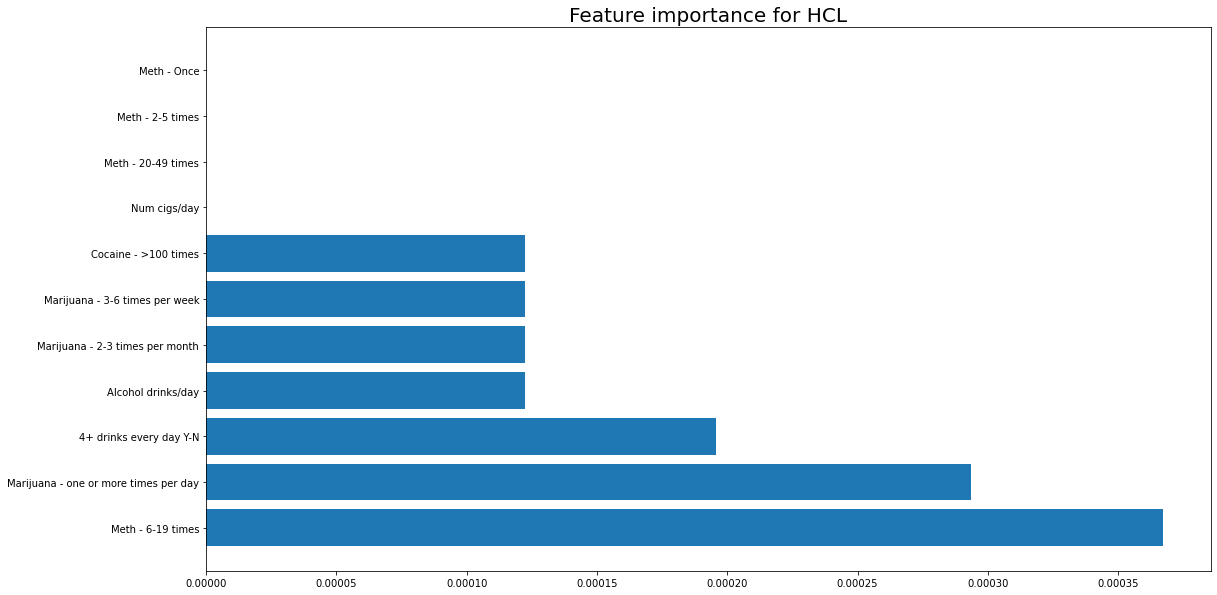

In [93]:
plot_features(NHANES_2013_2018_predictions, 'HCL', 'Substances', 'LRC feature name', 'LRC feature importance')

## Diabetes

### Demographic Category

In [94]:
features_names_Diabetes_demo, \
feat_importance_Diabetes_demo, \
models_scores_Diabetes_demo = feature_importance(health_df = Demographic_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have HCL', 
                                       col3 = 'Have diabetes', 
                                       category = 'Demographic', 
                                       condition = 'Diabetes', 
                                       no_conditions_df = demo_no_conditions, 
                                       save = False)


LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


In [95]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_Diabetes_demo, 
              feat_importance_Diabetes_demo,
              models_scores_Diabetes_demo,
              'Diabetes',
              'Demographic'
             )

In [96]:
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [97]:
NHANES_2013_2018_predictions.tail(34)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
410,Diabetes,Demographic,70-79,0.008836,0.864905,Gender - F,0.0,0.865272,60-69,0.295191,0.862702,60-69,0.113945,0.864905,18-29,0.00563,0.691263
411,Diabetes,Demographic,60-69,0.007979,0.864905,"$65,000 to \$74,999",0.0,0.865272,70-79,0.274115,0.862702,18-29,0.111674,0.864905,40-49,0.003255,0.691263
412,Diabetes,Demographic,80+,0.005042,0.864905,"$55,000 to \$64,999",0.0,0.865272,80+,0.132905,0.862702,Num family members,0.086786,0.864905,"$100,000 and Over",0.003109,0.691263
413,Diabetes,Demographic,50-59,0.002252,0.864905,"$45,000 to \$54,999",0.0,0.865272,50-59,0.116474,0.862702,30-39,0.082053,0.864905,Mexican American,0.002668,0.691263
414,Diabetes,Demographic,Mexican American,0.000857,0.864905,"$35,000 to \$44,999",0.0,0.865272,Mexican American,0.093412,0.862702,70-79,0.072627,0.864905,30-39,0.002154,0.691263
415,Diabetes,Demographic,"$5,000 to \$9,999",0.000563,0.864905,"$25,000 to \$34,999",0.0,0.865272,40-49,0.051324,0.862702,Less than 9th grade,0.033499,0.864905,"$45,000 to \$54,999",0.002032,0.691263
416,Diabetes,Demographic,"$20,000 to \$24,999",0.000514,0.864905,"$20,000 to \$24,999",0.0,0.865272,White,0.036579,0.862702,White,0.032437,0.864905,"$5,000 to \$9,999",0.00164,0.691263
417,Diabetes,Demographic,Num family members,0.000294,0.864905,"$15,000 to \$19,999",0.0,0.865272,"$15,000 to \$19,999",0.0,0.862702,Mexican American,0.031139,0.864905,"Under \$20,000",0.001469,0.691263
418,Diabetes,Demographic,White,0.00022,0.864905,"$10,000 to \$14,999",0.0,0.865272,"$0 to \$4,999",0.0,0.862702,College or above,0.029212,0.864905,College - AA,0.001297,0.691263
419,Diabetes,Demographic,"$10,000 to \$14,999",0.000171,0.864905,"$5,000 to \$9,999",0.0,0.865272,"$5,000 to \$9,999",0.0,0.862702,80+,0.027028,0.864905,"$75,000 to \$99,999",0.00115,0.691263


In [98]:
print(models_scores_Diabetes_demo['Accuracy'])
print(max(models_scores_Diabetes_demo['Accuracy']))

LRC    0.864905
SVM    0.865272
DTC    0.862702
RFC    0.864905
GNB    0.691263
Name: Accuracy, dtype: float64
0.8652716593245228


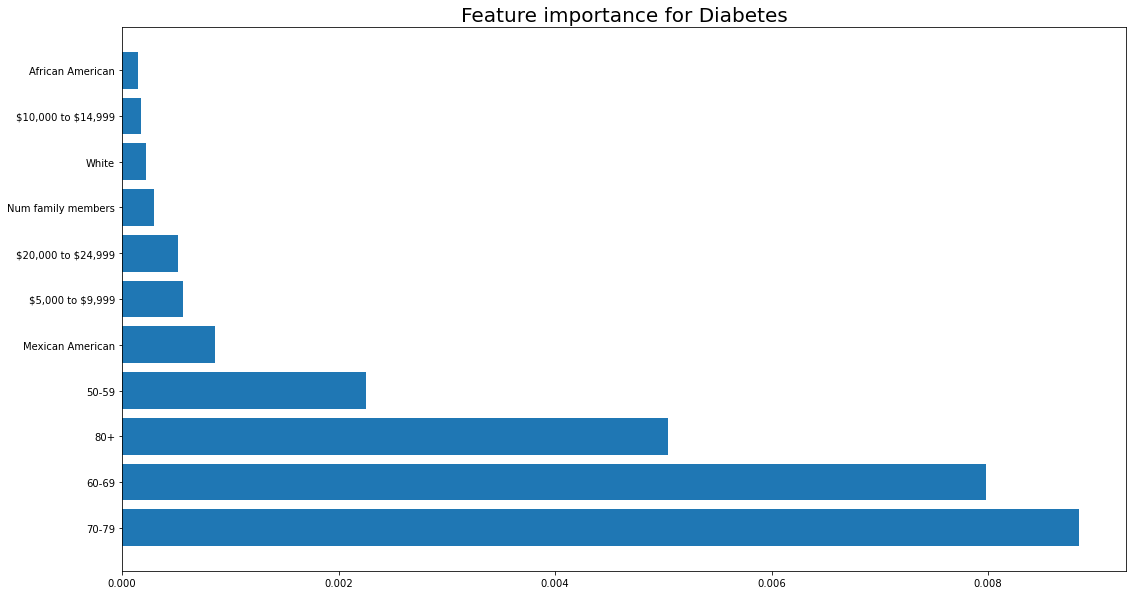

In [99]:
plot_features(NHANES_2013_2018_predictions, 'Diabetes', 'Demographic', 'LRC feature name', 'LRC feature importance')

## Dietary category

In [100]:
features_names_Diabetes_diet, \
feat_importance_Diabetes_diet, \
models_scores_Diabetes_diet = feature_importance(health_df = Dietary_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have HCL', 
                                       col3 = 'Have diabetes', 
                                       category = 'Dietary', 
                                       condition = 'Diabetes', 
                                       no_conditions_df = diet_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GNB


In [101]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_Diabetes_diet, 
              feat_importance_Diabetes_diet,
              models_scores_Diabetes_diet,
              'Diabetes',
              'Dietary'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [102]:
NHANES_2013_2018_predictions.tail(16)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
444,Diabetes,Dietary,Water (g),0.001493,0.866373,BMI - Underweight,0.0,0.865272,On special diet Y-N,1.0,0.865272,Total sugars (g),0.227861,0.865272,On special diet Y-N,0.018309,0.788179
445,Diabetes,Dietary,On special diet Y-N,0.00093,0.866373,BMI - Normal,0.0,0.865272,BMI - Underweight,0.0,0.865272,Cholesterol (mg),0.167322,0.865272,Fish past 30 days Y-N,0.002864,0.788179
446,Diabetes,Dietary,Total sugars (g),0.000906,0.866373,BMI - Overweight,0.0,0.865272,BMI - Normal,0.0,0.865272,Water (g),0.159701,0.865272,Total sugars (g),0.001934,0.788179
447,Diabetes,Dietary,BMI - Obesity,0.00049,0.866373,BMI - Obesity,0.0,0.865272,BMI - Overweight,0.0,0.865272,Moisture (g),0.157037,0.865272,Shellfish past 30 days Y-N,0.001469,0.788179
448,Diabetes,Dietary,Cholesterol (mg),0.000465,0.866373,DASH,0.0,0.865272,BMI - Obesity,0.0,0.865272,On special diet Y-N,0.095991,0.865272,Paleo,0.001224,0.788179
449,Diabetes,Dietary,USDA Balanced,0.000269,0.866373,Mediterranean,0.0,0.865272,DASH,0.0,0.865272,BMI - Obesity,0.056379,0.865272,DASH,0.000906,0.788179
450,Diabetes,Dietary,BMI - Normal,0.00022,0.866373,Paleo,0.0,0.865272,Mediterranean,0.0,0.865272,BMI - Normal,0.028028,0.865272,Cholesterol (mg),0.000685,0.788179
451,Diabetes,Dietary,BMI - Overweight,0.000122,0.866373,USDA Balanced,0.0,0.865272,Paleo,0.0,0.865272,Shellfish past 30 days Y-N,0.020162,0.865272,USDA Balanced,-0.000245,0.788179
452,Diabetes,Dietary,Moisture (g),0.000073,0.866373,Unbalanced,0.0,0.865272,USDA Balanced,0.0,0.865272,Unbalanced,0.016019,0.865272,BMI - Underweight,-0.000269,0.788179
453,Diabetes,Dietary,BMI - Underweight,0.0,0.866373,On special diet Y-N,0.0,0.865272,Unbalanced,0.0,0.865272,Fish past 30 days Y-N,0.015618,0.865272,Water (g),-0.000465,0.788179


In [103]:
print(models_scores_Diabetes_diet['Accuracy'])
print(max(models_scores_Diabetes_diet['Accuracy']))

LRC    0.866373
SVM    0.865272
DTC    0.865272
RFC    0.865272
GNB    0.788179
Name: Accuracy, dtype: float64
0.8663729809104258


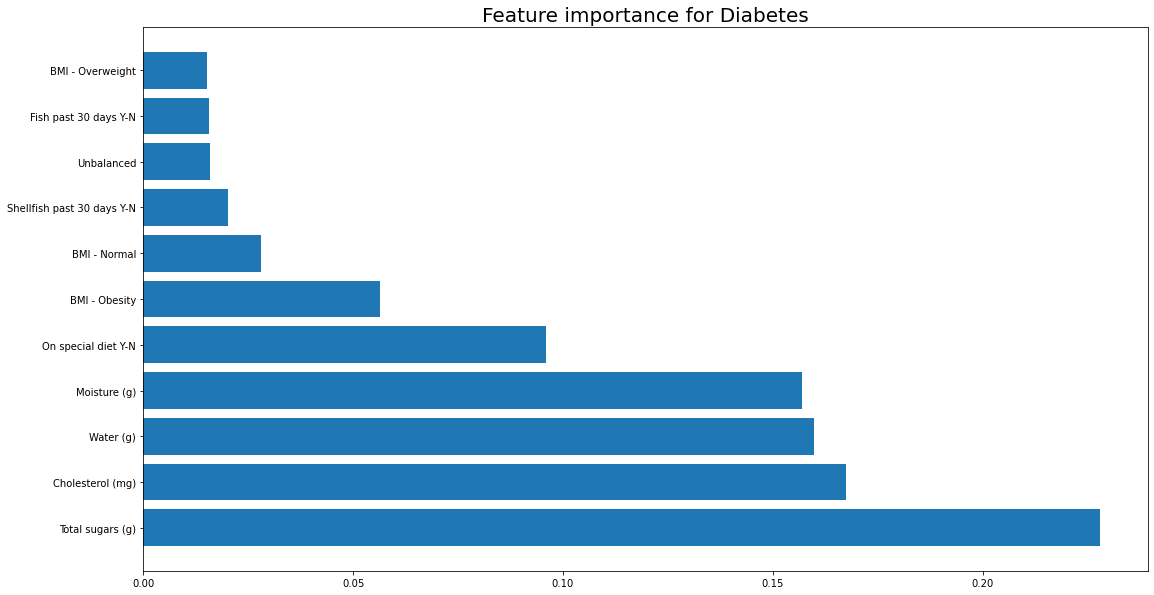

In [104]:
plot_features(NHANES_2013_2018_predictions, 'Diabetes', 'Dietary', 'RFC feature name', 'RFC feature importance')

## Lifestyle category

In [105]:
features_names_Diabetes_life, \
feat_importance_Diabetes_life, \
models_scores_Diabetes_life = feature_importance(health_df = Lifestyle_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have HCL', 
                                       col3 = 'Have diabetes', 
                                       category = 'Lifestyle', 
                                       condition = 'Diabetes', 
                                       no_conditions_df = life_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_Diabetes_life, 
              feat_importance_Diabetes_life,
              models_scores_Diabetes_life,
              'Diabetes',
              'Lifestyle'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [108]:
NHANES_2013_2018_predictions.tail(16)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
456,Diabetes,Dietary,Fish past 30 days Y-N,-0.0,0.866373,Moisture (g),0.0,0.865272,Moisture (g),0.0,0.865272,Mediterranean,0.011521,0.865272,BMI - Overweight,-0.003378,0.788179
457,Diabetes,Dietary,Mediterranean,-0.000024,0.866373,Water (g),0.0,0.865272,Water (g),0.0,0.865272,DASH,0.010979,0.865272,Unbalanced,-0.004749,0.788179
458,Diabetes,Dietary,DASH,-0.000049,0.866373,Shellfish past 30 days Y-N,0.0,0.865272,Shellfish past 30 days Y-N,0.0,0.865272,Paleo,0.003251,0.865272,BMI - Normal,-0.005434,0.788179
459,Diabetes,Dietary,Shellfish past 30 days Y-N,-0.000465,0.866373,Fish past 30 days Y-N,0.0,0.865272,Fish past 30 days Y-N,0.0,0.865272,BMI - Underweight,0.001782,0.865272,BMI - Obesity,-0.007,0.788179
460,Diabetes,Lifestyle,DS taken Y-N,0.000024,0.865272,Num days/week physical activity,0.0,0.865272,Num days/week physical activity,1.0,0.865272,Num days/week physical activity,0.135209,0.864905,Num meals not home prepared,0.00514,0.170338
461,Diabetes,Lifestyle,Num DS taken daily,0.0,0.865272,Hours/day sedentary activity,0.0,0.865272,Hours/day sedentary activity,0.0,0.865272,\$ spent eating out,0.121743,0.864905,Num meals from fast food,0.004993,0.170338
462,Diabetes,Lifestyle,\$ spent carryout/delivered foods,0.0,0.865272,DS taken Y-N,0.0,0.865272,DS taken Y-N,0.0,0.865272,Hours/day sedentary activity,0.117099,0.864905,\$ spent eating out,0.00235,0.170338
463,Diabetes,Lifestyle,Num meals not home prepared,0.0,0.865272,Num DS taken daily,0.0,0.865272,Num DS taken daily,0.0,0.865272,\$ spent supermarket/grocery store,0.114813,0.864905,Num days/week physical activity,0.001248,0.170338
464,Diabetes,Lifestyle,Num meals from fast food,0.0,0.865272,\$ spent supermarket/grocery store,0.0,0.865272,\$ spent supermarket/grocery store,0.0,0.865272,\$ spent for food at other stores,0.096663,0.864905,Num DS taken daily,0.001224,0.170338
465,Diabetes,Lifestyle,Num ready-to-eat foods,0.0,0.865272,\$ spent for food at other stores,0.0,0.865272,\$ spent for food at other stores,0.0,0.865272,Num meals not home prepared,0.075129,0.864905,\$ spent for food at other stores,0.001028,0.170338


In [109]:
print(models_scores_Diabetes_life['Accuracy'])
print(max(models_scores_Diabetes_life['Accuracy']))

LRC    0.865272
SVM    0.865272
DTC    0.865272
RFC    0.864905
GNB    0.170338
Name: Accuracy, dtype: float64
0.8652716593245228


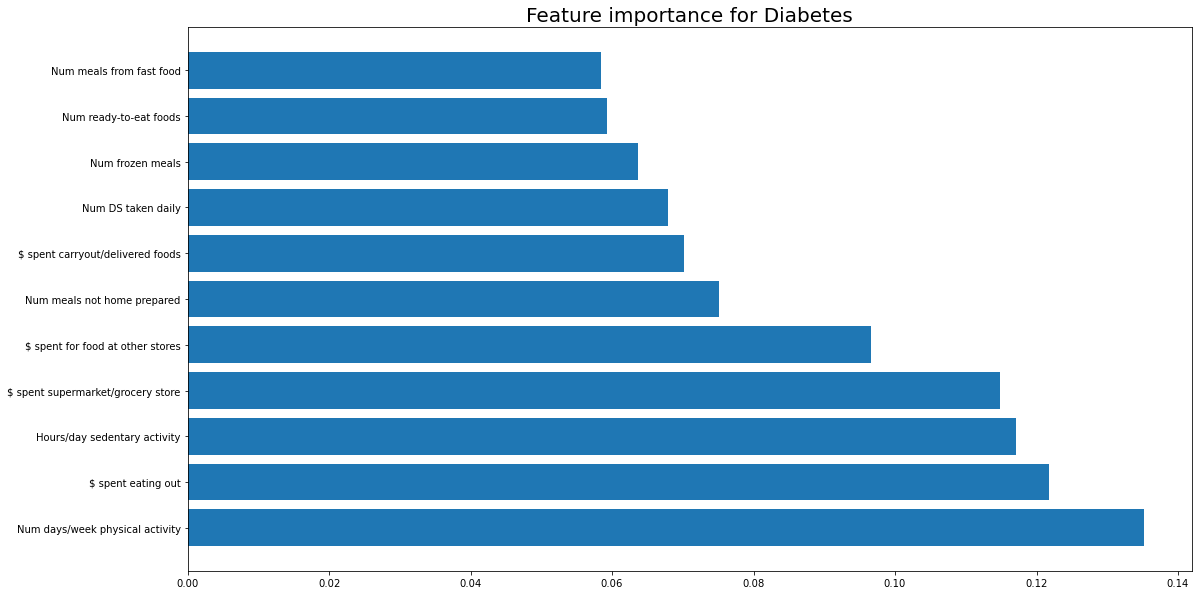

In [110]:
plot_features(NHANES_2013_2018_predictions, 'Diabetes', 'Lifestyle', 'RFC feature name', 'RFC feature importance')

## Lifestyle - Substances

In [111]:
features_names_Diabetes_subs, \
feat_importance_Diabetes_subs, \
models_scores_Diabetes_subs = feature_importance(health_df = Substances_df, 
                                       col1 = 'Have HBP', 
                                       col2 = 'Have HCL', 
                                       col3 = 'Have diabetes', 
                                       category = 'Substances', 
                                       condition = 'Diabetes', 
                                       no_conditions_df = subs_no_conditions, 
                                       save = False)

LRC
SVM


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DTC
RFC
GNB


/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescascipioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Substances_df.describe()

In [112]:
keys = ['LRC', 'SVM', 'DTC', 'RFC', 'GNB']
df = final_df(keys, 
              features_names_Diabetes_subs, 
              feat_importance_Diabetes_subs,
              models_scores_Diabetes_subs,
              'Diabetes',
              'Substances'
             )
NHANES_2013_2018_predictions = pd.concat([NHANES_2013_2018_predictions, df], ignore_index=True)

In [113]:
NHANES_2013_2018_predictions.tail(20)

,Condition,Features category,LRC feature name,LRC feature importance,LRC model accuracy,SVM feature name,SVM feature importance,SVM model accuracy,DTC feature name,DTC feature importance,DTC model accuracy,RFC feature name,RFC feature importance,RFC model accuracy,GNB feature name,GNB feature importance,GNB model accuracy
472,HBP,Substances,Num cigs/day,0.0,0.865272,Num cigs/day,0.0,0.865272,Alcohol drinks/day,1.0,0.865272,Alcohol drinks/day,0.378149,0.865272,Marijuana - 2-3 times per month,0.000979,0.313877
473,HBP,Substances,Meth - 20-49 times,0.0,0.865272,Meth - 20-49 times,0.0,0.865272,Num cigs/day,0.0,0.865272,Marijuana - one or more times per day,0.131795,0.865272,Marijuana - Once per month,0.000587,0.313877
474,HBP,Substances,Meth - 6-19 times,0.0,0.865272,Meth - 6-19 times,0.0,0.865272,Meth - 50-99 times,0.0,0.865272,Marijuana - 3-6 times per week,0.104443,0.865272,Num cigs/day,0.000024,0.313877
475,HBP,Substances,Meth - 2-5 times,0.0,0.865272,Meth - 2-5 times,0.0,0.865272,Meth - 20-49 times,0.0,0.865272,4+ drinks every day Y-N,0.085966,0.865272,Meth - >100 times,-0.000024,0.313877
476,HBP,Substances,Meth - Once,0.0,0.865272,Meth - Once,0.0,0.865272,Meth - 6-19 times,0.0,0.865272,Num cigs/day,0.078981,0.865272,4+ drinks every day Y-N,-0.000514,0.313877
477,HBP,Substances,Cocaine - >100 times,0.0,0.865272,Cocaine - >100 times,0.0,0.865272,Meth - 2-5 times,0.0,0.865272,Cocaine - 2-5 times,0.054834,0.865272,Cocaine - Once,-0.000857,0.313877
478,HBP,Substances,Cocaine - 50-99 times,0.0,0.865272,Cocaine - 50-99 times,0.0,0.865272,Meth - Once,0.0,0.865272,Marijuana - 1-2 times per week,0.025552,0.865272,Meth - Once,-0.001664,0.313877
479,HBP,Substances,Cocaine - 20-49 times,0.0,0.865272,Cocaine - 20-49 times,0.0,0.865272,Cocaine - >100 times,0.0,0.865272,Cocaine - >100 times,0.020944,0.865272,Meth - 50-99 times,-0.002056,0.313877
480,HBP,Substances,Cocaine - 6-19 times,0.0,0.865272,Cocaine - 6-19 times,0.0,0.865272,Cocaine - 50-99 times,0.0,0.865272,Cocaine - Once,0.016913,0.865272,Marijuana - 3-6 times per week,-0.002154,0.313877
481,HBP,Substances,Cocaine - 2-5 times,0.0,0.865272,Cocaine - 2-5 times,0.0,0.865272,Cocaine - 20-49 times,0.0,0.865272,Cocaine - 20-49 times,0.01256,0.865272,Marijuana - 1-2 times per week,-0.002227,0.313877


In [114]:
print(models_scores_Diabetes_subs['Accuracy'])
print(max(models_scores_Diabetes_subs['Accuracy']))

LRC    0.865272
SVM    0.865272
DTC    0.865272
RFC    0.865272
GNB    0.313877
Name: Accuracy, dtype: float64
0.8652716593245228


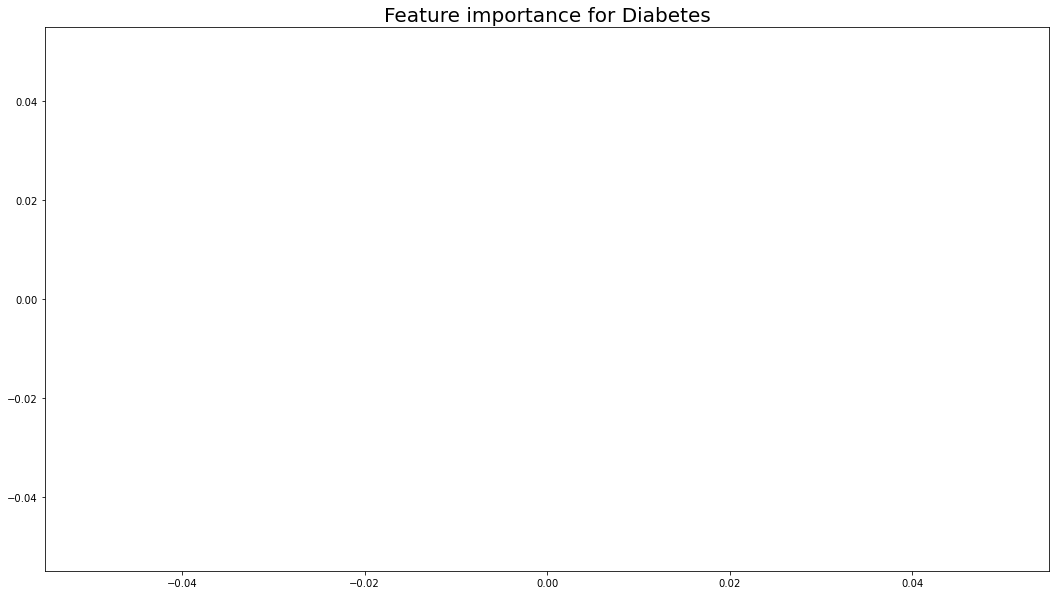

In [115]:
plot_features(NHANES_2013_2018_predictions, 'Diabetes', 'Substances', 'GNB feature name', 'GNB feature importance')

In [116]:
# Save the clean NHANES DataFrame in a .csv file
NHANES_2013_2018_predictions.to_csv('FINAL_DATASETS/NHANES_2013_2018_predictions.csv')